## Prepare Environment

In [ ]:
!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers
!pip install librosa
!pip install evaluate>=0.30
!pip install jiwer
!pip install gradio
!pip install audiomentations
!pip install transformers==4.30.0
!pip install accelerate==0.20.3

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-dxj6_6bb
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-dxj6_6bb
  Resolved https://github.com/huggingface/transformers to commit 3cbc560d03035481eecdc4bdc3a0b19628cdac08
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.9 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.32.0.dev0-py3-none-any.whl size=7447579 sha256=ba795364a71c674866b04b353d4a5b3e92cf0376aa13cf5bf24502119d3ad2ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-o7j4b7e9/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1

In [ ]:
import random
import librosa
import numpy as np
import soundfile as sf

In [ ]:
from audiomentations import Compose

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


## Load and Normalize Dataset

In [ ]:
!pip install num2words
!pip install transliterate
#!pip install cylimiter
#!pip install pyroomacoustics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=0d298f28fe8efd1ab477c24b57ea3c05dfb1fcd9f64a08e7f266f7b2974fc5bb
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 865.7 kB/s eta 0:00:00


In [ ]:
import re
from num2words import num2words  #num2words(42, lang='ru')
from nltk import word_tokenize
from transliterate import translit
import nltk

chars_to_ignore_regex = '[\,\?\.\!\-\;\:\«\»\"\(\)]'
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def convert_numbers(line):
        line = word_tokenize(line)
        a = line
        a = [int(x) if x.isdigit()== True else x for x in a]
        b = [num2words(x, lang='ru') if type(x)==int else x for x in a]
        c = ' '.join(b)
        #d = c.replace(' £££ ', '\n')
        return c

In [ ]:
def norm_string(text):
  return translit(convert_numbers(re.sub(chars_to_ignore_regex, '', text).lower()), language_code='ru')

In [ ]:
def norm_ds_text(batch):
  batch['transcription'] = norm_string(batch['transcription'])

In [ ]:
from audiomentations import Compose, AddGaussianNoise, Limiter, TimeStretch, RoomSimulator, PitchShift, Shift, AddBackgroundNoise, PolarityInversion, AddGaussianSNR
augment = Compose([
    Limiter(
        min_threshold_db=-16.0,
        max_threshold_db=-6.0,
        threshold_mode="relative_to_signal_peak",
        p=1.0,
      ),
    RoomSimulator(
        min_mic_distance=5.0,
        max_mic_distance=20.0,
        padding=2.0,
        use_ray_tracing=False,
        p=1.0,
    ),
    AddGaussianSNR(
      min_snr_db=20.0,
      max_snr_db=70.0,
      p=1.0
    ),
    AddGaussianNoise(
      min_amplitude=0.01,
      max_amplitude=0.2,
      p=1.0
    ),
    #TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    #PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    #Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
    AddBackgroundNoise(
    sounds_path="./noise",
    noise_rms="relative",
    min_snr_in_db=3.0,
    max_snr_in_db=30.0,
    min_absolute_rms_db=-20.0,
    max_absolute_rms_db=-3.0,
    noise_transform=PolarityInversion(),
    p=1.0
    ),
    AddBackgroundNoise(
    sounds_path="./noise",
    noise_rms="absolute",
    min_snr_in_db=3.0,
    max_snr_in_db=30.0,
    min_absolute_rms_db=-20.0,
    max_absolute_rms_db=-3.0,
    noise_transform=PolarityInversion(),
    p=1.0
    ),
    AddBackgroundNoise(
    sounds_path="./noise",
    noise_rms="absolute",
    min_snr_in_db=35.0,
    max_snr_in_db=50.0,
    min_absolute_rms_db=-30.0,
    max_absolute_rms_db=-3.0,
    noise_transform=PolarityInversion(),
    p=1.0
    )
])
# augmented_samples = augment(samples=samples, sample_rate=16000)

In [ ]:
def noise_ds_audio(batch, sample_rate=16000):
  aug = augment(batch['audio']['array'], sample_rate=16000)
  batch['audio']['array'] = aug

In [ ]:
from datasets import load_dataset, DatasetDict, concatenate_datasets, load_metric

In [ ]:
from datasets import load_dataset, DatasetDict, concatenate_datasets, load_metric

speech_clean_ds = DatasetDict()
text_ds = DatasetDict()

golos_far_train = load_dataset("bond005/sberdevices_golos_100h_farfield", split="train+validation") #Noisy ~11.3h / validation 1.0h
golos_far_test = load_dataset("bond005/sberdevices_golos_100h_farfield", split="test") #Noisy ~1.4h

#sova_rudevices_train = load_dataset("bond005/sova_rudevices", split="train+validation", use_auth_token=True) #Noisy ~88.3h / validation 5.9h
#sova_rudevices_test = load_dataset("bond005/sova_rudevices", split="test", use_auth_token=True) #Noisy ~5.8h

golos_crowd_train = load_dataset("bond005/sberdevices_golos_10h_crowd", split="train+validation") # ~9.8h / validation ~0.9h
golos_crowd_test = load_dataset("bond005/sberdevices_golos_10h_crowd", split="test") # 11.2h

#rulibrispeech_train = load_dataset("bond005/rulibrispeech", split="train+validation", use_auth_token=True) # h?
#rulibrispeech_test = load_dataset("bond005/rulibrispeech", split="test", use_auth_token=True) # h?

#rutexts_norm_train = load_dataset("bond005/ru_texts_normalized", split="train", use_auth_token=True)
#rutexts_norm_test = load_dataset("bond005/ru_texts_normalized", split="test", use_auth_token=True)

# ds_train_list = [common_voice_train, golos_far_train, sova_rudevices_train, golos_crowd_train, rulibrispeech_train]
# ds_test_list = [common_voice_test, golos_far_test, sova_rudevices_test, golos_crowd_test, rulibrispeech_test]

ds_train_list = [golos_far_train, golos_crowd_train, ]
ds_test_list = [golos_far_test, golos_crowd_test, ]

speech_ds_train = concatenate_datasets(ds_train_list)
speech_ds_test = concatenate_datasets(ds_test_list)

speech_clean_ds['train'] = speech_ds_train.train_test_split(test_size=0.01)['test']
speech_clean_ds['test'] = speech_ds_test.train_test_split(test_size=0.05)['test']

#text_ds['train'] = rutexts_norm_train.train_test_split(test_size=0.1)
#text_ds['test'] = rutexts_norm_test.train_test_split(test_size=0.1)

print(speech_clean_ds)

speech_clean_ds["train"] = speech_clean_ds["train"].filter(lambda x: x != None, input_columns=["transcription"])
speech_clean_ds["test"] = speech_clean_ds["test"].filter(lambda x: x != None, input_columns=["transcription"])

speech_clean_ds= speech_clean_ds.map(norm_ds_text)
speech_noise_ds= speech_clean_ds
speech_noise_ds['test']= speech_clean_ds['test']

print(speech_clean_ds)

In [ ]:
from IPython import display
display.Audio(data=speech_clean_ds["train"][1]['audio']['array'], rate=speech_clean_ds["train"][0]['audio']['sampling_rate'])

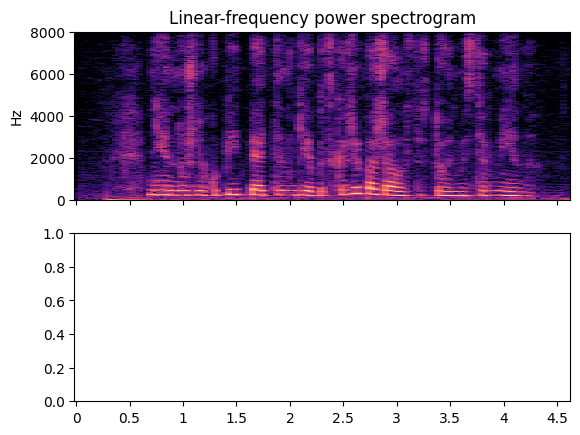

In [ ]:
y, sr = speech_clean_ds["train"][1]['audio']['array'], speech_clean_ds["train"][0]['audio']['sampling_rate']
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

## Prepare Feature Extractor, Tokenizer and Data

### Prepare Data

https://huggingface.co/spaces/sentencebird/audio-noise-reduction/blob/91914f1490133d20b13b84c05146dc0b23fe9768/app.py

https://huggingface.co/tasks/audio-to-audio

https://colab.research.google.com/drive/18RyiuKupAhwWX7fh3LCatwQGU5eIS3TR?usp=sharing

https://huggingface.co/nguyenvulebinh/wav2vec2-noisy

In [ ]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, AddBackgroundNoise, PolarityInversion, AddGaussianSNR
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

In [ ]:
print(speech_clean_ds["train"][0])

{'audio': {'path': None, 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -6.10351562e-05, -1.83105469e-04, -3.05175781e-05]), 'sampling_rate': 16000}, 'transcription': 'порхов'}


In [ ]:
from datasets import Audio, Dataset, DatasetDict

speech_clean_ds = speech_clean_ds.cast_column("audio", Audio(sampling_rate=16000)) #Приведем к формату Whisper

In [ ]:
print(speech_clean_ds["train"][0])

{'audio': {'path': None, 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -6.10351562e-05, -1.83105469e-04, -3.05175781e-05]), 'sampling_rate': 16000}, 'transcription': 'порхов'}


In [ ]:
from IPython import display
display.Audio(data=speech_clean_ds["train"][0]['audio']['array'], rate=speech_clean_ds["train"][0]['audio']['sampling_rate'])

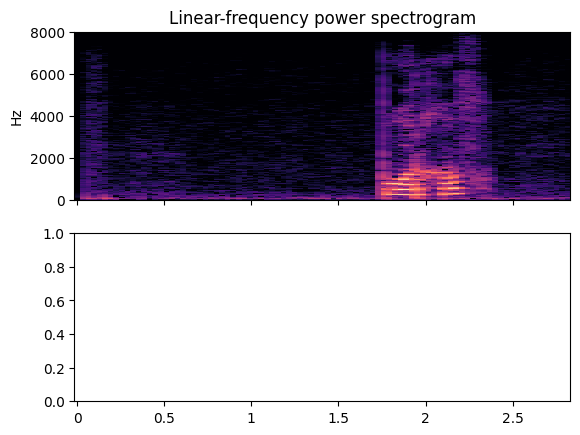

In [ ]:
y, sr = speech_clean_ds["train"][0]['audio']['array'], speech_clean_ds["train"][0]['audio']['sampling_rate']
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

In [ ]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

augment = Compose([
    #AddGaussianSNR(
    #  min_snr_db=4.0,
    #  max_snr_db=50.0,
    #  p=1.0
    #),
    #TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    #PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    #Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
    #AddBackgroundNoise(
    #sounds_path="./ESC-50-master/audio",
    #min_snr_in_db=10.0,
    #max_snr_in_db=50.0,
    #noise_transform=PolarityInversion(),
    #p=1.0
    #),
    AddBackgroundNoise(
    sounds_path="./noise",
    min_snr_in_db=20.0,
    max_snr_in_db=50.0,
    noise_transform=PolarityInversion(),
    p=1.0
    )
])

# Generate 2 seconds of dummy audio for the sake of example
samples = speech_clean_ds["train"][0]['audio']['array']
print(samples)
# Augment/transform/perturb the audio data
augmented_samples = augment(samples=samples, sample_rate=16000)
display.Audio(augmented_samples, rate=speech_clean_ds["train"][0]['audio']['sampling_rate'])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.10351562e-05
 -1.83105469e-04 -3.05175781e-05]


/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


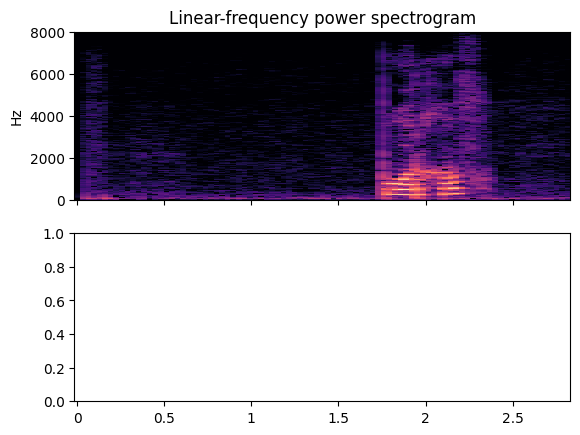

In [ ]:
y, sr = speech_clean_ds["train"][0]['audio']['array'], speech_clean_ds["train"][0]['audio']['sampling_rate']
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

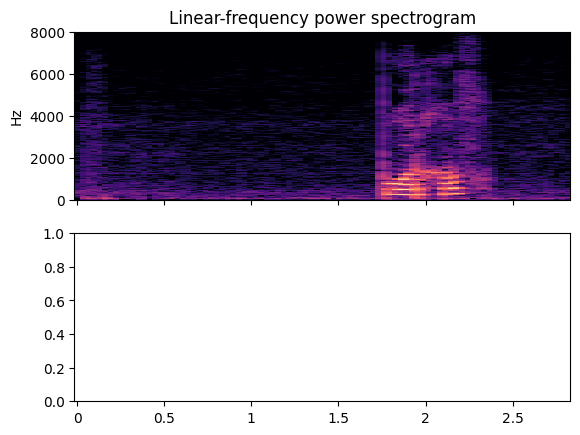

In [ ]:
y, sr = augmented_samples, speech_clean_ds["train"][0]['audio']['sampling_rate']
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

In [ ]:
def prepare_dataset(batch): # Вот здесь можно аугментацией добавить аудио...
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # augmented_sound = augment(audio["array"], sample_rate=audio["sampling_rate"]) # зашумит набор еще сильнее

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["transcription"]).input_ids
    return batch

In [ ]:
speech_ds = speech_clean_ds.map(prepare_dataset, remove_columns=speech_clean_ds.column_names["train"], num_proc=4)

Map (num_proc=4):   0%|          | 0/1929 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1184 [00:00<?, ? examples/s]

#Whisper

##Evaluate without VAD, Denoiser and SpellChecker on clean and noisy data

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration, pipeline

In [ ]:
pipe = pipeline("automatic-speech-recognition",model="openai/whisper-medium", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio, generate_kwargs = {"task":"transcribe", "language":"<|ru|>"})["text"]
    return text

In [ ]:
def map_res(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  batch["pred_str"] = norm_string(text)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = speech_clean_ds["test"].map(map_res, remove_columns=speech_clean_ds["test"].column_names)

Map:   0%|          | 0/1177 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/1177 [00:00<?, ? examples/s]

In [ ]:
print("pred : true")
for i in range(len(results_clean['pred_str'][:30])):
  print(f"{results_clean['pred_str'][i]} : {results_clean['text'][i]}")

pred : true
мясина : мессина
найти лучшие фильмы жанра фэнтези : найти лучшие фильмы жанра фэнтези
запусти друзья : запусти друзья
стоимость доставки заказа в отеле : стоимость доставки заказа в отель
друзья одиннадцать сезон двадцать серия : друзья одиннадцатый сезон двадцатая серия
боевик : боевик
между командами ливерпоол и арсенал : футбол между командами ливерпуль и арсенал
запустить телеканал москва24 : запустить телеканал москва двадцать четыре
футбольный матч между командами ливерпоол – манчестер циты : футбольный матч между командами ливерпуль манчестер сити
открою серию тридцать один как я встретил вашу маму : открой серию тридцать один как я встретил вашу маму
александр николаевич юлдошев : александр николаевич юлдошев
отголоски ключи : отголоски включи
афина дудина наталья умеет вязать спицами : афина дудина наталья умеет вязать спицами
кино работа переменная облачность поставь : киноработа переменная облачность поставь
рим девять сезон одиннадцать эпизод : рим девятый сезо

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

<ipython-input-138-0dc5f81e0ca6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [ ]:
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test clean WER: 0.227
Test clean CER: 0.080
Test noise WER: 0.227
Test noise CER: 0.080


##Evaluate with VAD and without Denoiser

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration, pipeline
pipe = pipeline("automatic-speech-recognition",model="openai/whisper-medium", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio, generate_kwargs = {"task":"transcribe", "language":"<|ru|>"})["text"]
    return text

In [ ]:
import torch
USE_ONNX = False # change this to True if you want to test onnx model
if USE_ONNX:
    !pip install -q onnxruntime

device = torch.device('cuda')
vad, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True,
                              onnx=USE_ONNX,)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


In [ ]:
display.Audio(data=speech_clean_ds["train"][0]["audio"]['array'], rate=speech_clean_ds["train"][0]['audio']['sampling_rate'])

In [ ]:
wav = torch.from_numpy(speech_clean_ds["train"][0]["audio"]['array'])
audio = speech_clean_ds["train"][0]["audio"]['array']
print(len(audio))
speech_timestamps = get_speech_timestamps(audio, vad, sampling_rate=16000, speech_pad_ms=500,
                                          threshold=0.46, min_speech_duration_ms=100,  window_size_samples=512)
audio = collect_chunks(speech_timestamps, wav)
len(audio)

42731


20288

In [ ]:
display.Audio(data=audio, rate=speech_clean_ds["train"][0]['audio']['sampling_rate'])

In [ ]:
def map_res_vad(batch, processor_sf=16000):
  audio = batch["audio"]['array']
  try:
    speech_timestamps = get_speech_timestamps(audio, vad, sampling_rate=16000, speech_pad_ms=500,
                                          threshold=0.46, min_speech_duration_ms=100,  window_size_samples=512)
    audio = collect_chunks(speech_timestamps, torch.from_numpy(batch["audio"]['array'])).numpy()
  except Exception as e:
    print(e)
    audio = batch["audio"]['array']
  text = transcribe(audio)
  batch["pred_str"] = norm_string(text)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = speech_clean_ds["test"].map(map_res_vad, remove_columns=speech_clean_ds["test"].column_names)

Map:   0%|          | 0/591 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors


Map:   0%|          | 0/591 [00:00<?, ? examples/s]

torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors


In [ ]:
print("pred : true")
for i in range(len(results_clean['pred_str'][:30])):
  print(f"{results_clean['pred_str'][i]} : {results_clean['text'][i]}")

pred : true
расскажи подробно про лыжи в отеле : расскажи подробно про лыжи в отеле
маринникова : маренникова
помыла голову и увидела что нет фена принесите фен : помыла голову увидела что нет фена принесите фен
салют я люблю тебя больше всех на свете : салют я люблю тебя больше всех на свете
владимир васильевич гусейнов : владимир васильевич гусейнов
найди мне все серии сериала друзья : найди мне все серии сериала друзья
алиса расскажи о подробности и ремонте одежды в отеле : алиса расскажи про подробности и ремонте одежды в отеле
кондитер на пятницу : кондитер на пятнице
мультфильм зверополис сша : мультфильм зверополис сша
афина почему нельзя есть козявки : афина почему нельзя есть козявки
если в этом отеле переговорная комната : есть ли в этом отеле переговорная комната
пополнить мобильный баланс : пополнить мобильный баланс
спортивный мир ближайший : спортивный мир ближайший
шесть триллионов триста сорок три миллиарда шестьсот сорок девять миллионов шестьсот тридцать восемь тысяч 

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test clean WER: 0.239
Test clean CER: 0.089
Test noise WER: 0.239
Test noise CER: 0.089


##Evaluate without VAD with YaSpeller on clean data

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration, pipeline

In [ ]:
!pip install pyaspeller

In [ ]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()
fixed = speller.spelled('Triky Custle is a great puzzle game.')

In [ ]:
pipe = pipeline("automatic-speech-recognition",model="openai/whisper-medium", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio, generate_kwargs = {"task":"transcribe", "language":"<|ru|>"})["text"]
    return text

In [ ]:
def map_res_lm(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  fixed = speller.spelled(text)

  batch["pred_str"] = norm_string(fixed)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = speech_clean_ds["test"].map(map_res_lm, remove_columns=speech_clean_ds["test"].column_names)

Map:   0%|          | 0/591 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/591 [00:00<?, ? examples/s]

In [ ]:
print("pred : true")
for i in range(len(results_clean['pred_str'][:30])):
  print(f"{results_clean['pred_str'][i]} : {results_clean['text'][i]}")

pred : true
расскажи подробно про лыжи в отеле : расскажи подробно про лыжи в отеле
маренникова : маренникова
помыла голову и увидела что нет фена принесите фен : помыла голову увидела что нет фена принесите фен
салют я люблю тебя больше всех на свете : салют я люблю тебя больше всех на свете
владимир васильевич гусейнов : владимир васильевич гусейнов
найди мне все серии сериала друзья : найди мне все серии сериала друзья
алиса расскажи о подробности и ремонте одежды в отеле : алиса расскажи про подробности и ремонте одежды в отеле
кондитерская пятница : кондитер на пятнице
мультфильм зверополис сша : мультфильм зверополис сша
а финна почему нельзя есть козявки : афина почему нельзя есть козявки
если в этом отеле переговорная комната : есть ли в этом отеле переговорная комната
пополнить мобильный баланс : пополнить мобильный баланс
спортивный мир ближайший : спортивный мир ближайший
шесть триллионов триста сорок три миллиарда шестьсот сорок девять миллионов шестьсот тридцать восемь тыс

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

<ipython-input-31-0dc5f81e0ca6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [ ]:
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test clean WER: 0.211
Test clean CER: 0.083
Test noise WER: 0.211
Test noise CER: 0.083


##Evaluate with VAD and with YaSpeller

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration, pipeline
pipe = pipeline("automatic-speech-recognition",model="openai/whisper-medium", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio, generate_kwargs = {"task":"transcribe", "language":"<|ru|>"})["text"]
    return text

In [ ]:
!pip install pyaspeller

NotImplementedError: ignored

In [ ]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()
fixed = speller.spelled('Triky Custle is a great puzzle game.')

In [ ]:
import torch
USE_ONNX = False # change this to True if you want to test onnx model
if USE_ONNX:
    !pip install -q onnxruntime

device = torch.device('cuda')
vad, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True,
                              onnx=USE_ONNX,)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

In [ ]:
display.Audio(data=speech_clean_ds["train"][0]["audio"]['array'], rate=speech_clean_ds["train"][0]['audio']['sampling_rate'])

In [ ]:
wav = torch.from_numpy(speech_clean_ds["train"][0]["audio"]['array'])
audio = speech_clean_ds["train"][0]["audio"]['array']
print(len(audio))
speech_timestamps = get_speech_timestamps(audio, vad, sampling_rate=16000, speech_pad_ms=500,
                                          threshold=0.46, min_speech_duration_ms=100,  window_size_samples=512)
audio = collect_chunks(speech_timestamps, wav)
len(audio)

42731


20288

In [ ]:
display.Audio(data=audio, rate=speech_clean_ds["train"][0]['audio']['sampling_rate'])

In [ ]:
def map_res_vad_lm(batch, processor_sf=16000):
  audio = batch["audio"]['array']
  try:
    speech_timestamps = get_speech_timestamps(audio, vad, sampling_rate=16000, speech_pad_ms=500,
                                          threshold=0.46, min_speech_duration_ms=100,  window_size_samples=512)
    audio = collect_chunks(speech_timestamps, torch.from_numpy(batch["audio"]['array'])).numpy()
  except Exception as e:
    print(e)
    audio = batch["audio"]['array']
  text = transcribe(audio)
  fixed = speller.spelled(text)
  batch["pred_str"] = norm_string(fixed)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = speech_clean_ds["test"].map(map_res_vad_lm, remove_columns=speech_clean_ds["test"].column_names)

Map:   0%|          | 0/591 [00:00<?, ? examples/s]

torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors


In [ ]:
print("pred : true")
for i in range(len(results_clean['pred_str'][:30])):
  print(f"{results_clean['pred_str'][i]} : {results_clean['text'][i]}")

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

##Evaluate with VAD and with LM T5 Не использовалось

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration, pipeline
pipe = pipeline("automatic-speech-recognition",model="openai/whisper-medium", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio, generate_kwargs = {"task":"transcribe", "language":"<|ru|>"})["text"]
    return text

KeyboardInterrupt: ignored

In [ ]:
import torch
USE_ONNX = False # change this to True if you want to test onnx model
if USE_ONNX:
    !pip install -q onnxruntime

device = torch.device('cuda')
vad, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True,
                              onnx=USE_ONNX,)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


In [ ]:
# Импортируем библиотеки
from transformers import AutoModelForSeq2SeqLM, T5TokenizerFast
# Зададим название выбронной модели из хаба
MODEL_NAME = 'UrukHan/t5-russian-spell'
MAX_INPUT = 256
# Загрузка модели и токенизатора
tokenizer = T5TokenizerFast.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

In [ ]:
display.Audio(data=speech_clean_ds["train"][0]["audio"]['array'], rate=speech_clean_ds["train"][0]['audio']['sampling_rate'])

In [ ]:
wav = torch.from_numpy(speech_clean_ds["train"][0]["audio"]['array'])
audio = speech_clean_ds["train"][0]["audio"]['array']
print(len(audio))
speech_timestamps = get_speech_timestamps(audio, vad, sampling_rate=16000, speech_pad_ms=500,
                                          threshold=0.46, min_speech_duration_ms=100,  window_size_samples=512)
audio = collect_chunks(speech_timestamps, wav)
len(audio)

42731


20288

In [ ]:
display.Audio(data=audio, rate=speech_clean_ds["train"][0]['audio']['sampling_rate'])

In [ ]:
def map_res_vad_lm(batch, processor_sf=16000):
  audio = batch["audio"]['array']
  try:
    speech_timestamps = get_speech_timestamps(audio, vad, sampling_rate=16000, speech_pad_ms=500,
                                          threshold=0.46, min_speech_duration_ms=100,  window_size_samples=512)
    audio = collect_chunks(speech_timestamps, torch.from_numpy(batch["audio"]['array'])).numpy()
  except Exception as e:
    print(e)
    audio = batch["audio"]['array']
  text = transcribe(audio)
  input_sequences = [text]
  # Токенизирование данных
  task_prefix = "Spell correct: "
  if type(input_sequences) != list: input_sequences = [input_sequences]
  encoded = tokenizer(
    [task_prefix + sequence for sequence in input_sequences],
    padding="longest",
    max_length=MAX_INPUT,
    truncation=True,
    return_tensors="pt",
  )
  # Прогнозирование
  predicts = model.generate(**encoded.to(device))
  # Декодируем данные
  text = tokenizer.batch_decode(predicts, skip_special_tokens=True)[0]

  batch["pred_str"] = norm_string(text)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = speech_clean_ds["test"].map(map_res_vad, remove_columns=speech_clean_ds["test"].column_names)
results_noise = speech_noise_ds["test"].map(map_res_vad, remove_columns=speech_noise_ds["test"].column_names)

Map:   0%|          | 0/1177 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors


In [ ]:
print("pred : true")
for i in range(len(results_clean['pred_str'][:30])):
  print(f"{results_clean['pred_str'][i]} : {results_clean['text'][i]}")

In [ ]:
print("pred : true")
for i in range(len(results_noise['pred_str'][:30])):
  print(f"{results_noise['pred_str'][i]} : {results_noise['text'][i]}")

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test noise WER: {:.3f}".format(wer_metric.compute(predictions=results_noise["pred_str"], references=results_noise["text"])))
print("Test noise CER: {:.3f}".format(cer_metric.compute(predictions=results_noise["pred_str"], references=results_noise["text"])))

##Evaluate without VAD and with Denoiser on relatively clean data

In [ ]:
!pip install -U denoiser

NotImplementedError: ignored

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration, pipeline
from denoiser import pretrained
from denoiser.dsp import convert_audio
from IPython import display as disp

ModuleNotFoundError: ignored

In [ ]:
pipe = pipeline("automatic-speech-recognition",model="openai/whisper-medium", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio, generate_kwargs = {"task":"transcribe", "language":"<|ru|>"})["text"]
    return text

In [ ]:
wav = torch.from_numpy(speech_clean_ds["train"][0]["audio"]['array'])
wav = convert_audio(wav.cuda(), sr, model.sample_rate, model.chin)
with torch.no_grad():
    denoised = model(wav[None])[0]
disp.display(disp.Audio(wav.data.cpu().numpy(), rate=model.sample_rate))
disp.display(disp.Audio(denoised.data.cpu().numpy(), rate=model.sample_rate))

In [ ]:
def map_res(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  batch["pred_str"] = norm_string(text)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results = speech_clean_ds["test"].map(map_res, remove_columns=speech_clean_ds["test"].column_names)

Map:   0%|          | 0/118 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
print("pred : true")
for i in range(len(results['pred_str'][:100])):
  print(f"{results['pred_str'][i]} : {results['text'][i]}")

pred : true
подборка мтв : подборка эм ти ви
тейлор свифт христос три фарм : тейлор свифт кристмас три фарм
закажи черный заварной чай : закажи черный заварной чай
афинас крой приложение : афина скрой приложение
джой сделай яркость на минимум один : джой сделай яркость на минимум в ванной
афина как избавиться от траканов : афина как избавиться от тараканов
фильм с шайя лабафом с названием « девушка » : фильм с шайа лабафом с названием девушка
есть ли у тебя будучи там : есть ли у тебя будучи там
бородино : бородино
телефон фермер : телефон фермер
в отеле есть лазер так : в отеле есть лазертаг
джой ближайший путь к банкомату : джой ближайший путь к банкомату
включи как кинематографический фильм обитаемый остров : включи ка кинематографический фильм обитаемый остров
поисковик на один фильм в жанре артхаус : поисковик найди мне фильм в жанре артхаус
включи капкан : включи капкан
врубины тв стар : вруби на тв стар
суперженщины : супер женщины
да не : да не
галины афанасьевны : галины афана

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

<ipython-input-23-0dc5f81e0ca6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test WER: 0.223
Test CER: 0.078


#Wav2vec with LM

##Evaluate without VAD, Denoiser and SpellChecker on clean data

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("automatic-speech-recognition",model="bond005/wav2vec2-large-ru-golos-with-lm", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

Could not load the `decoder` for bond005/wav2vec2-large-ru-golos-with-lm. Defaulting to raw CTC. Error: No module named 'kenlm'
Try to install `kenlm`: `pip install kenlm
Try to install `pyctcdecode`: `pip install pyctcdecode


In [ ]:
def map_res(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  batch["pred_str"] = norm_string(text)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = speech_clean_ds["test"].map(map_res, remove_columns=speech_clean_ds["test"].column_names)
results_noise = speech_noise_ds["test"].map(map_res, remove_columns=speech_noise_ds["test"].column_names)

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/590 [00:00<?, ? examples/s]

In [ ]:
print("pred : true")
for i in range(len(results_clean['pred_str'][:30])):
  print(f"{results_clean['pred_str'][i]} : {results_clean['text'][i]}")

pred : true
какой предвавительный курс английского фунта на завтра : какой предварительный курс английского фунта на завтра
пополни телефон коллеги : пополнить телефон коллеге
сто тридцать баксов это сколько шекелей : сто тридцать баксов это сколько шекелей
найди на смотрешке телеканал нано тв : найди на смотрешке телеканал нано тв
врубай канал шансон тв на смотрешке : врубай канал шансон тв на смотрешке
поставь исполнителя маркусверба : поставь исполнителя маркус верба
есть ли в отеле салоны связи : есть ли в отеле салоны связи
невеста и презрасутки : невеста и предрассудки
сбер запусти телевизионный канал успех : сбер запусти телевизионный канал успех
алексей каротков : алексей коротков
поиск любимые команды манчестер юнайтед матча : поиск любимые команды манчестер юнайтед матчи
на ютубе открой миксы : на ютубе открой миксы
хабаровске : хабаровске
сбер что такое финансовый банк : сбер что такое финансовый банк
мусихину : мусихину
живой кальян : живой кальян
у тебя найдется ледяная ма

In [ ]:
print("pred : true")
for i in range(len(results_noise['pred_str'][:30])):
  print(f"{results_noise['pred_str'][i]} : {results_noise['text'][i]}")

pred : true
какой предвавительный курс английского фунта на завтра : какой предварительный курс английского фунта на завтра
пополни телефон коллеги : пополнить телефон коллеге
сто тридцать баксов это сколько шекелей : сто тридцать баксов это сколько шекелей
найди на смотрешке телеканал нано тв : найди на смотрешке телеканал нано тв
врубай канал шансон тв на смотрешке : врубай канал шансон тв на смотрешке
поставь исполнителя маркусверба : поставь исполнителя маркус верба
есть ли в отеле салоны связи : есть ли в отеле салоны связи
невеста и презрасутки : невеста и предрассудки
сбер запусти телевизионный канал успех : сбер запусти телевизионный канал успех
алексей каротков : алексей коротков
поиск любимые команды манчестер юнайтед матча : поиск любимые команды манчестер юнайтед матчи
на ютубе открой миксы : на ютубе открой миксы
хабаровске : хабаровске
сбер что такое финансовый банк : сбер что такое финансовый банк
мусихину : мусихину
живой кальян : живой кальян
у тебя найдется ледяная ма

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

<ipython-input-26-0dc5f81e0ca6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [ ]:
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test noise WER: {:.3f}".format(wer_metric.compute(predictions=results_noise["pred_str"], references=results_noise["text"])))
print("Test noise CER: {:.3f}".format(cer_metric.compute(predictions=results_noise["pred_str"], references=results_noise["text"])))

Test clean WER: 0.124
Test clean CER: 0.028
Test noise WER: 0.124
Test noise CER: 0.028


##Evaluate with VAD on clean data

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("automatic-speech-recognition",model="bond005/wav2vec2-large-ru-golos-with-lm", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

Could not load the `decoder` for bond005/wav2vec2-large-ru-golos-with-lm. Defaulting to raw CTC. Error: No module named 'kenlm'
Try to install `kenlm`: `pip install kenlm
Try to install `pyctcdecode`: `pip install pyctcdecode


In [ ]:
import torch
USE_ONNX = False # change this to True if you want to test onnx model
if USE_ONNX:
    !pip install -q onnxruntime

device = torch.device('cuda')
vad, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True,
                              onnx=USE_ONNX,)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


In [ ]:
def map_res_vad(batch, processor_sf=16000):
  audio = batch["audio"]['array']
  try:
    speech_timestamps = get_speech_timestamps(audio, vad, sampling_rate=16000, speech_pad_ms=500,
                                          threshold=0.46, min_speech_duration_ms=100,  window_size_samples=512)
    audio = collect_chunks(speech_timestamps, torch.from_numpy(batch["audio"]['array'])).numpy()
  except Exception as e:
    print(e)
    audio = batch["audio"]['array']
  text = transcribe(audio)
  batch["pred_str"] = norm_string(text)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = speech_clean_ds["test"].map(map_res_vad, remove_columns=speech_clean_ds["test"].column_names)
results_noise = speech_noise_ds["test"].map(map_res_vad, remove_columns=speech_noise_ds["test"].column_names)

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors


Map:   0%|          | 0/590 [00:00<?, ? examples/s]

torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors


In [ ]:
print("pred : true")
for i in range(len(results_clean['pred_str'][:30])):
  print(f"{results_clean['pred_str'][i]} : {results_clean['text'][i]}")

pred : true
какой предвавительный курс английского фунта на завтра : какой предварительный курс английского фунта на завтра
пополни телефон коллеги : пополнить телефон коллеге
сто тридцать баксов это сколько шекелей : сто тридцать баксов это сколько шекелей
найди на смотрешке телеканал нано тв : найди на смотрешке телеканал нано тв
врубай канал шансон тв на смотрешке : врубай канал шансон тв на смотрешке
поставь исполнителя маркусверба : поставь исполнителя маркус верба
есть ли в отеле салоны связи : есть ли в отеле салоны связи
невеста и преграсутки : невеста и предрассудки
сбер запусти телевизионный канал успех : сбер запусти телевизионный канал успех
алексей коротков : алексей коротков
поиск любимые команды манчестер юнайтед матча : поиск любимые команды манчестер юнайтед матчи
на ютубе открой миксы : на ютубе открой миксы
хабаровске : хабаровске
сбер что такое финансовый банк : сбер что такое финансовый банк
мусихину : мусихину
живой кальян : живой кальян
у тебя найдется ледяная ма

In [ ]:
print("pred : true")
for i in range(len(results_noise['pred_str'][:30])):
  print(f"{results_noise['pred_str'][i]} : {results_noise['text'][i]}")

pred : true
какой предвавительный курс английского фунта на завтра : какой предварительный курс английского фунта на завтра
пополни телефон коллеги : пополнить телефон коллеге
сто тридцать баксов это сколько шекелей : сто тридцать баксов это сколько шекелей
найди на смотрешке телеканал нано тв : найди на смотрешке телеканал нано тв
врубай канал шансон тв на смотрешке : врубай канал шансон тв на смотрешке
поставь исполнителя маркусверба : поставь исполнителя маркус верба
есть ли в отеле салоны связи : есть ли в отеле салоны связи
невеста и преграсутки : невеста и предрассудки
сбер запусти телевизионный канал успех : сбер запусти телевизионный канал успех
алексей коротков : алексей коротков
поиск любимые команды манчестер юнайтед матча : поиск любимые команды манчестер юнайтед матчи
на ютубе открой миксы : на ютубе открой миксы
хабаровске : хабаровске
сбер что такое финансовый банк : сбер что такое финансовый банк
мусихину : мусихину
живой кальян : живой кальян
у тебя найдется ледяная ма

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test noise WER: {:.3f}".format(wer_metric.compute(predictions=results_noise["pred_str"], references=results_noise["text"])))
print("Test noise CER: {:.3f}".format(cer_metric.compute(predictions=results_noise["pred_str"], references=results_noise["text"])))

Test clean WER: 0.136
Test clean CER: 0.041
Test noise WER: 0.136
Test noise CER: 0.041


##Evaluate with YaSpeller on clean data

In [ ]:
!pip install pyaspeller

In [ ]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()
fixed = speller.spelled('Triky Custle is a great puzzle game.')

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("automatic-speech-recognition",model="bond005/wav2vec2-large-ru-golos-with-lm", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

Could not load the `decoder` for bond005/wav2vec2-large-ru-golos-with-lm. Defaulting to raw CTC. Error: No module named 'kenlm'
Try to install `kenlm`: `pip install kenlm
Try to install `pyctcdecode`: `pip install pyctcdecode


In [ ]:
def map_res_spell(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  fixed = speller.spelled(text)

  batch["pred_str"] = norm_string(fixed)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = speech_clean_ds["test"].map(map_res_spell, remove_columns=speech_clean_ds["test"].column_names)
results_noise = speech_noise_ds["test"].map(map_res_spell, remove_columns=speech_noise_ds["test"].column_names)

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/590 [00:00<?, ? examples/s]

In [ ]:
print("pred : true")
for i in range(len(results_clean['pred_str'][:30])):
  print(f"{results_clean['pred_str'][i]} : {results_clean['text'][i]}")

pred : true
какой предварительный курс английского фунта на завтра : какой предварительный курс английского фунта на завтра
пополни телефон коллеги : пополнить телефон коллеге
сто тридцать баксов это сколько шекелей : сто тридцать баксов это сколько шекелей
найди на смотришке телеканал нано тв : найди на смотрешке телеканал нано тв
врубай канал шансон тв на матрешке : врубай канал шансон тв на смотрешке
поставь исполнителя маркус верба : поставь исполнителя маркус верба
есть ли в отеле салоны связи : есть ли в отеле салоны связи
невеста и предрассудки : невеста и предрассудки
сбер запустил телевизионный канал успех : сбер запусти телевизионный канал успех
алексей коротков : алексей коротков
поиск любимые команды манчестер юнайтед матча : поиск любимые команды манчестер юнайтед матчи
на ютубе открой миксы : на ютубе открой миксы
хабаровске : хабаровске
сбер что такое финансовый банк : сбер что такое финансовый банк
мусихину : мусихину
живой кальян : живой кальян
у тебя найдется ледяная 

In [ ]:
print("pred : true")
for i in range(len(results_noise['pred_str'][:30])):
  print(f"{results_noise['pred_str'][i]} : {results_noise['text'][i]}")

pred : true
какой предварительный курс английского фунта на завтра : какой предварительный курс английского фунта на завтра
пополни телефон коллеги : пополнить телефон коллеге
сто тридцать баксов это сколько шекелей : сто тридцать баксов это сколько шекелей
найди на смотришке телеканал нано тв : найди на смотрешке телеканал нано тв
врубай канал шансон тв на матрешке : врубай канал шансон тв на смотрешке
поставь исполнителя маркус верба : поставь исполнителя маркус верба
есть ли в отеле салоны связи : есть ли в отеле салоны связи
невеста и предрассудки : невеста и предрассудки
сбер запустил телевизионный канал успех : сбер запусти телевизионный канал успех
алексей коротков : алексей коротков
поиск любимые команды манчестер юнайтед матча : поиск любимые команды манчестер юнайтед матчи
на ютубе открой миксы : на ютубе открой миксы
хабаровске : хабаровске
сбер что такое финансовый банк : сбер что такое финансовый банк
мусихину : мусихину
живой кальян : живой кальян
у тебя найдется ледяная 

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test noise WER: {:.3f}".format(wer_metric.compute(predictions=results_noise["pred_str"], references=results_noise["text"])))
print("Test noise CER: {:.3f}".format(cer_metric.compute(predictions=results_noise["pred_str"], references=results_noise["text"])))

Test clean WER: 0.090
Test clean CER: 0.024
Test noise WER: 0.090
Test noise CER: 0.024


##Evaluate with VAD and YaSpeller on clean data

In [ ]:
!pip install pyaspeller

In [ ]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()
fixed = speller.spelled('Triky Custle is a great puzzle game.')

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("automatic-speech-recognition",model="bond005/wav2vec2-large-ru-golos-with-lm", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

Could not load the `decoder` for bond005/wav2vec2-large-ru-golos-with-lm. Defaulting to raw CTC. Error: No module named 'kenlm'
Try to install `kenlm`: `pip install kenlm
Try to install `pyctcdecode`: `pip install pyctcdecode


In [ ]:
import torch
USE_ONNX = False # change this to True if you want to test onnx model
if USE_ONNX:
    !pip install -q onnxruntime

device = torch.device('cuda')
vad, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True,
                              onnx=USE_ONNX,)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


In [ ]:
def map_res_vad_spell(batch):
  audio = batch["audio"]['array']
  try:
    speech_timestamps = get_speech_timestamps(audio, vad, sampling_rate=16000, speech_pad_ms=500,
                                          threshold=0.46, min_speech_duration_ms=100,  window_size_samples=512)
    audio = collect_chunks(speech_timestamps, torch.from_numpy(batch["audio"]['array'])).numpy()
  except Exception as e:
    print(e)
    audio = batch["audio"]['array']
  text = transcribe(audio)
  fixed = speller.spelled(text)

  batch["pred_str"] = norm_string(fixed)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = speech_clean_ds["test"].map(map_res_spell, remove_columns=speech_clean_ds["test"].column_names)
results_noise = speech_noise_ds["test"].map(map_res_spell, remove_columns=speech_noise_ds["test"].column_names)

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/590 [00:00<?, ? examples/s]

In [ ]:
print("pred : true")
for i in range(len(results_clean['pred_str'][:30])):
  print(f"{results_clean['pred_str'][i]} : {results_clean['text'][i]}")

pred : true
какой предварительный курс английского фунта на завтра : какой предварительный курс английского фунта на завтра
пополни телефон коллеги : пополнить телефон коллеге
сто тридцать баксов это сколько шекелей : сто тридцать баксов это сколько шекелей
найди на смотришке телеканал нано тв : найди на смотрешке телеканал нано тв
врубай канал шансон тв на матрешке : врубай канал шансон тв на смотрешке
поставь исполнителя маркус верба : поставь исполнителя маркус верба
есть ли в отеле салоны связи : есть ли в отеле салоны связи
невеста и предрассудки : невеста и предрассудки
сбер запустил телевизионный канал успех : сбер запусти телевизионный канал успех
алексей коротков : алексей коротков
поиск любимые команды манчестер юнайтед матча : поиск любимые команды манчестер юнайтед матчи
на ютубе открой миксы : на ютубе открой миксы
хабаровске : хабаровске
сбер что такое финансовый банк : сбер что такое финансовый банк
мусихину : мусихину
живой кальян : живой кальян
у тебя найдется ледяная 

In [ ]:
print("pred : true")
for i in range(len(results_noise['pred_str'][:30])):
  print(f"{results_noise['pred_str'][i]} : {results_noise['text'][i]}")

pred : true
какой предварительный курс английского фунта на завтра : какой предварительный курс английского фунта на завтра
пополни телефон коллеги : пополнить телефон коллеге
сто тридцать баксов это сколько шекелей : сто тридцать баксов это сколько шекелей
найди на смотришке телеканал нано тв : найди на смотрешке телеканал нано тв
врубай канал шансон тв на матрешке : врубай канал шансон тв на смотрешке
поставь исполнителя маркус верба : поставь исполнителя маркус верба
есть ли в отеле салоны связи : есть ли в отеле салоны связи
невеста и предрассудки : невеста и предрассудки
сбер запустил телевизионный канал успех : сбер запусти телевизионный канал успех
алексей коротков : алексей коротков
поиск любимые команды манчестер юнайтед матча : поиск любимые команды манчестер юнайтед матчи
на ютубе открой миксы : на ютубе открой миксы
хабаровске : хабаровске
сбер что такое финансовый банк : сбер что такое финансовый банк
мусихину : мусихину
живой кальян : живой кальян
у тебя найдется ледяная 

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test noise WER: {:.3f}".format(wer_metric.compute(predictions=results_noise["pred_str"], references=results_noise["text"])))
print("Test noise CER: {:.3f}".format(cer_metric.compute(predictions=results_noise["pred_str"], references=results_noise["text"])))

Test clean WER: 0.090
Test clean CER: 0.024
Test noise WER: 0.090
Test noise CER: 0.024


#Wav2vec without LM

##Evaluate without VAD, Denoiser and SpellChecker on clean data

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("automatic-speech-recognition",model="bond005/wav2vec2-large-ru-golos", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

In [ ]:
def map_res(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  batch["pred_str"] = norm_string(text)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = speech_clean_ds["test"].map(map_res, remove_columns=speech_clean_ds["test"].column_names)

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/590 [00:00<?, ? examples/s]

In [ ]:
print("pred : true")
for i in range(len(results_clean['pred_str'][:30])):
  print(f"{results_clean['pred_str'][i]} : {results_clean['text'][i]}")

pred : true
афина какой официальный язык в романовской империи : афина какой официальный язык в романовской империи
салют поставь конный мир : салют поставь конный мир
король лев : король лев
включи мультик рожденная звездой вторая часть : включи мультик рожденная звездой вторая часть
ты мне найдешь мультфильм и эй спортс фифа : ты мне найдешь мультфильм и эй спортс фифа
салют карту потеряла по номеру телефона могу : салют карту потеряла по номеру телефона могу
включи телеканал известия на телевизоре : включи телеканал известия на телевизоре
афина выйдете за меня замуж : афина выйдите за меня замуж
джой набери рябов : джой набери рябых
закажи мне вискас для котят жидкий : закажи мне вискас для котят жидкий
кинематографический фильм брикл бери набери : кинематографический фильм бриклберри набери
салют хочу оформить кредит кому я могу обратиться : салют хочу оформить кредит к кому я могу обратиться
кино : кино
сбер найди канал телевидения наше новое кино : сбер найди канал телевидения на

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

<ipython-input-26-0dc5f81e0ca6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [ ]:
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test clean WER: 0.119
Test clean CER: 0.027
Test noise WER: 0.119
Test noise CER: 0.027


##Evaluate with VAD on clean data

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("automatic-speech-recognition",model="bond005/wav2vec2-large-ru-golos", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

Could not load the `decoder` for bond005/wav2vec2-large-ru-golos-with-lm. Defaulting to raw CTC. Error: No module named 'kenlm'
Try to install `kenlm`: `pip install kenlm
Try to install `pyctcdecode`: `pip install pyctcdecode


In [ ]:
import torch
USE_ONNX = False # change this to True if you want to test onnx model
if USE_ONNX:
    !pip install -q onnxruntime

device = torch.device('cuda')
vad, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True,
                              onnx=USE_ONNX,)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


In [ ]:
def map_res_vad(batch, processor_sf=16000):
  audio = batch["audio"]['array']
  try:
    speech_timestamps = get_speech_timestamps(audio, vad, sampling_rate=16000, speech_pad_ms=500,
                                          threshold=0.46, min_speech_duration_ms=100,  window_size_samples=512)
    audio = collect_chunks(speech_timestamps, torch.from_numpy(batch["audio"]['array'])).numpy()
  except Exception as e:
    print(e)
    audio = batch["audio"]['array']
  text = transcribe(audio)
  batch["pred_str"] = norm_string(text)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = speech_clean_ds["test"].map(map_res_vad, remove_columns=speech_clean_ds["test"].column_names)

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors


Map:   0%|          | 0/590 [00:00<?, ? examples/s]

torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors


In [ ]:
print("pred : true")
for i in range(len(results_clean['pred_str'][:30])):
  print(f"{results_clean['pred_str'][i]} : {results_clean['text'][i]}")

pred : true
скажи пожалуйста где здесь за пастной выход в отеле : скажи пожалуйста где здесь запасной выход в отеле
хочу смотреть сейчас дрейк : хочу смотреть сейчас дрейк
лен тв : лен тв
джой предыдующий трешк : джой предыдущий трек
покажи мне на тв айди : покажи мне на тв ай ди
старшая сестра : старшая сестра
афина найти альбом фил юло : афина найди альбом фил ю лов
найти кино управление гневом : найти кино управление гневом
лот как скоро проясняются мутные глаза змеи : салют как скоро проясняются мутные глаза змеи
здорово виртуальный ассистент грудо метололома пожалуйста найди мне подробности прокурения в отеле : здорово виртуальный ассистент груда металлолома пожалуйста найди мне подробности про курение в отеле
сериал дерево желаний нарой : сериал дерево желаний нарой
красному сулину : красному сулину
салют перезвони михаилу : салют перезвони михаилу
афина закажи большой сладки под сериал : афина закажи большой сладкий под сериал
город мечты сезон одиннадцать тринадцатая часть : го

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test clean WER: 0.145
Test clean CER: 0.053
Test noise WER: 0.145
Test noise CER: 0.053


##Evaluate with YaSpeller on clean data

In [ ]:
!pip install pyaspeller

In [ ]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()
fixed = speller.spelled('Triky Custle is a great puzzle game.')

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("automatic-speech-recognition",model="bond005/wav2vec2-large-ru-golos", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

In [ ]:
def map_res_spell(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  fixed = speller.spelled(text)

  batch["pred_str"] = norm_string(fixed)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = speech_clean_ds["test"].map(map_res_spell, remove_columns=speech_clean_ds["test"].column_names)

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/590 [00:00<?, ? examples/s]

In [ ]:
print("pred : true")
for i in range(len(results_clean['pred_str'][:30])):
  print(f"{results_clean['pred_str'][i]} : {results_clean['text'][i]}")

pred : true
скажи пожалуйста где здесь запасной выход в отеле : скажи пожалуйста где здесь запасной выход в отеле
хочу смотреть сейчас дрейк : хочу смотреть сейчас дрейк
лен тв : лен тв
джой предыдущий трек : джой предыдущий трек
покажи мне на тв айди : покажи мне на тв ай ди
старшая сестра : старшая сестра
афина найти альбом фил юло : афина найди альбом фил ю лов
найти кино управление гневом : найти кино управление гневом
салют как скоро проясняются мутные глаза змеи : салют как скоро проясняются мутные глаза змеи
здорово виртуальный ассистент груда металлолома пожалуйста найди мне подробности про курение в отеле : здорово виртуальный ассистент груда металлолома пожалуйста найди мне подробности про курение в отеле
сериал дерево желаний нарой : сериал дерево желаний нарой
красному сулину : красному сулину
салют перезвони михаилу : салют перезвони михаилу
афина закажи большой сладкий плод сериал : афина закажи большой сладкий под сериал
город мечты сезон одиннадцать тринадцатая часть : 

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test clean WER: 0.090
Test clean CER: 0.024
Test noise WER: 0.090
Test noise CER: 0.024


##Evaluate with VAD and YaSpeller on clean data

In [ ]:
!pip install pyaspeller

In [ ]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()
fixed = speller.spelled('Triky Custle is a great puzzle game.')

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("automatic-speech-recognition",model="bond005/wav2vec2-large-ru-golos", device='cuda')  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

Could not load the `decoder` for bond005/wav2vec2-large-ru-golos-with-lm. Defaulting to raw CTC. Error: No module named 'kenlm'
Try to install `kenlm`: `pip install kenlm
Try to install `pyctcdecode`: `pip install pyctcdecode


In [ ]:
import torch
USE_ONNX = False # change this to True if you want to test onnx model
if USE_ONNX:
    !pip install -q onnxruntime

device = torch.device('cuda')
vad, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True,
                              onnx=USE_ONNX,)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


In [ ]:
def map_res_vad_spell(batch):
  audio = batch["audio"]['array']
  try:
    speech_timestamps = get_speech_timestamps(audio, vad, sampling_rate=16000, speech_pad_ms=500,
                                          threshold=0.46, min_speech_duration_ms=100,  window_size_samples=512)
    audio = collect_chunks(speech_timestamps, torch.from_numpy(batch["audio"]['array'])).numpy()
  except Exception as e:
    print(e)
    audio = batch["audio"]['array']
  text = transcribe(audio)
  fixed = speller.spelled(text)

  batch["pred_str"] = norm_string(fixed)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = speech_clean_ds["test"].map(map_res_vad_spell, remove_columns=speech_clean_ds["test"].column_names)
results_noise = speech_noise_ds["test"].map(map_res_vad_spell, remove_columns=speech_noise_ds["test"].column_names)

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors


Map:   0%|          | 0/590 [00:00<?, ? examples/s]

torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors
torch.cat(): expected a non-empty list of Tensors


In [ ]:
print("pred : true")
for i in range(len(results_clean['pred_str'][:30])):
  print(f"{results_clean['pred_str'][i]} : {results_clean['text'][i]}")

pred : true
скажи пожалуйста где здесь запасной выход в отеле : скажи пожалуйста где здесь запасной выход в отеле
хочу смотреть сейчас дрейк : хочу смотреть сейчас дрейк
лен тв : лен тв
джой предыдущий трек : джой предыдущий трек
покажи мне на тв айди : покажи мне на тв ай ди
старшая сестра : старшая сестра
афина найти альбом фил юло : афина найди альбом фил ю лов
найти кино управление гневом : найти кино управление гневом
лот как скоро проясняются мутные глаза змеи : салют как скоро проясняются мутные глаза змеи
здорово виртуальный ассистент груда металлолома пожалуйста найди мне подробности про курение в отеле : здорово виртуальный ассистент груда металлолома пожалуйста найди мне подробности про курение в отеле
сериал дерево желаний нарой : сериал дерево желаний нарой
красному сулину : красному сулину
салют перезвони михаилу : салют перезвони михаилу
афина закажи большой сладки под сериал : афина закажи большой сладкий под сериал
город мечты сезон одиннадцать тринадцатая часть : горо

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

NameError: ignored

In [ ]:
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test clean WER: 0.117
Test clean CER: 0.049
Test noise WER: 0.117
Test noise CER: 0.049


# Evaluate Zero-Shot Best Version on True Data

In [ ]:
import soundfile as sf

In [ ]:
!pip install pyaspeller

In [ ]:
!pip install -U denoiser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 671.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for denoiser: filename=denoiser-0.1.5-py3-none-any.whl size=43826 sha256=2c98a8365744a75c65ac7cf6ed48f979af3f978aa5a5e34bf9e4f90a3021f83d
  Stored in directory: /root/.cache/pip/wheels/f1/57/3f/7ce0ae586d457c598b2cb275a37801ff5a705f656ba7a0215e
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7779 sha256=0947da18e19b11954e1818839dea6cc6e37ed7d08e8dd218911eae071c12878f
  Stored in directory: /root/.cache/pip/wheels/3b/ca/9e/5b5d6e5e109322303b50d21918ad2bd7d50a2a0775c11e08e8
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21878 sha256=d09947f2b076434896a6e8347d1965

In [ ]:
import torch
import torchaudio
from denoiser import pretrained
from denoiser.dsp import convert_audio
denoise = pretrained.dns64().cuda()

Downloading: "https://dl.fbaipublicfiles.com/adiyoss/denoiser/dns64-a7761ff99a7d5bb6.th" to /root/.cache/torch/hub/checkpoints/dns64-a7761ff99a7d5bb6.th
100%|██████████| 128M/128M [00:00<00:00, 138MB/s]


In [ ]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()
fixed = speller.spelled('Triky Custle is a great puzzle game.')

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="bond005/wav2vec2-large-ru-golos-with-lm")

Could not load the `decoder` for bond005/wav2vec2-large-ru-golos-with-lm. Defaulting to raw CTC. Error: No module named 'kenlm'
Try to install `kenlm`: `pip install kenlm
Try to install `pyctcdecode`: `pip install pyctcdecode


In [ ]:
def transcribe(audio):
    text = pipe(audio)["text"]
    return text

def transcribe_from_path_without_spell(audio_path):
    data, samplerate = sf.read(audio_path)
    text = pipe(data)['text']
    return text

def transcribe_from_path_with_spell(audio_path):
    data, samplerate = sf.read(audio_path)
    text = pipe(data)['text']
    fixed = speller.spelled(text)
    return fixed

def transcribe_from_path_without_spell_denoised(audio_path):
    wav, sr = torchaudio.load(audio_path)
    wav = convert_audio(wav.cuda(), sr, denoise.sample_rate, denoise.chin)
    with torch.no_grad():
      denoised = denoise(wav[None])[0].data.cpu().numpy()[0]
    text = pipe(denoised)['text']
    return text

def transcribe_from_path_with_spell_denoised(audio_path):
    wav, sr = torchaudio.load(audio_path)
    wav = convert_audio(wav.cuda(), sr, denoise.sample_rate, denoise.chin)
    with torch.no_grad():
      denoised = denoise(wav[None])[0].data.cpu().numpy()[0]
    text = pipe(denoised)['text']
    fixed = speller.spelled(text)
    return fixed

In [ ]:
iface = gr.Interface(
    fn=transcribe,
    inputs=gr.Audio(source="microphone", type="filepath"),
    outputs="text",
    title="Wav2Vec Large Russian",
    description="Realtime demo for Russian speech recognition using a Wav2Vec large model.",
)

iface.launch()

In [ ]:
!pip install glob

In [ ]:
import glob

# search all files inside a specific folder
# *.* means file name with any extension
dir_path = r'./robot/*.wav'
res = sorted(glob.glob(dir_path))
print(res)

['./robot/nv2m_audio_0.wav', './robot/nv2m_audio_1.wav', './robot/nv2m_audio_10.wav', './robot/nv2m_audio_11.wav', './robot/nv2m_audio_12.wav', './robot/nv2m_audio_13.wav', './robot/nv2m_audio_14.wav', './robot/nv2m_audio_15.wav', './robot/nv2m_audio_16.wav', './robot/nv2m_audio_17.wav', './robot/nv2m_audio_18.wav', './robot/nv2m_audio_19.wav', './robot/nv2m_audio_2.wav', './robot/nv2m_audio_20.wav', './robot/nv2m_audio_21.wav', './robot/nv2m_audio_22.wav', './robot/nv2m_audio_3.wav', './robot/nv2m_audio_4.wav', './robot/nv2m_audio_5.wav', './robot/nv2m_audio_6.wav', './robot/nv2m_audio_7.wav', './robot/nv2m_audio_8.wav', './robot/nv2m_audio_9.wav', './robot/nv_audio_0.wav', './robot/nv_audio_1.wav', './robot/nv_audio_10.wav', './robot/nv_audio_11.wav', './robot/nv_audio_12.wav', './robot/nv_audio_13.wav', './robot/nv_audio_14.wav', './robot/nv_audio_15.wav', './robot/nv_audio_16.wav', './robot/nv_audio_17.wav', './robot/nv_audio_18.wav', './robot/nv_audio_19.wav', './robot/nv_audio_2.

In [ ]:
# import pandas as pd
import pandas as pd

f_names = []
texts = []
for i in res:
  data, samplerate = sf.read(i)
  text = transcribe(data)
  fixed = speller.spelled(text)
  print(i)
  print(fixed)
  print()
  f_names.append(i)
  texts.append(fixed)

df = pd.DataFrame(list(zip(f_names, texts)),
               columns =['filenames', 'transcriptions'])
df.to_csv('noise_voice.csv', index=False,)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


./robot/nv2m_audio_0.wav
ес вперед два метра

./robot/nv2m_audio_1.wav
ет назад три метра

./robot/nv2m_audio_10.wav
повернись направо на десять редутов

./robot/nv2m_audio_11.wav
повернись налево там двадцать

./robot/nv2m_audio_12.wav
деть назад три метра

./robot/nv2m_audio_13.wav
кейсик человек черную

./robot/nv2m_audio_14.wav
депектиру женщины в классном

./robot/nv2m_audio_15.wav
этит перед три метра

./robot/nv2m_audio_16.wav
и до завтра не тратьте

./robot/nv2m_audio_17.wav
деть припаяться

./robot/nv2m_audio_18.wav
об есть пятятстьа

./robot/nv2m_audio_19.wav
как у тебя дела

./robot/nv2m_audio_2.wav
повернись направо на десять тракте

./robot/nv2m_audio_20.wav
какая с поля погода

./robot/nv2m_audio_21.wav
сколько тебе лет

./robot/nv2m_audio_22.wav


./robot/nv2m_audio_3.wav
повернись с налево в десять трансы

./robot/nv2m_audio_4.wav
детктерь

./robot/nv2m_audio_5.wav
едь к дивану

./robot/nv2m_audio_6.wav
возьми короллу

./robot/nv2m_audio_7.wav
дит назад

./robot/nv2m_au

In [ ]:
import pandas as pd
import soundfile as sf
true_ds = pd.read_csv('noise_voice.csv', ).dropna()

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

<ipython-input-12-0dc5f81e0ca6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [ ]:
true_ds['pred'] = true_ds['filenames'].apply(transcribe_from_path_without_spell)
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=true_ds['pred'], references=true_ds['transcriptions'])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=true_ds['pred'], references=true_ds['transcriptions'])))


Test clean WER: 0.620
Test clean CER: 0.260


In [ ]:
true_ds

filenames                        transcriptions  \
0    ./robot/nv2m_audio_0.wav                  едь вперед два метра   
1    ./robot/nv2m_audio_1.wav                   едь назад три метра   
2   ./robot/nv2m_audio_10.wav  повернись направо на десять градусов   
3   ./robot/nv2m_audio_11.wav     повернись налево на двадцать пять   
4   ./robot/nv2m_audio_12.wav                   едь назад три метра   
..                        ...                                   ...   
66     ./robot/rv_audio_5.wav               робот повернись направо   
67     ./robot/rv_audio_6.wav        двадцать градусов робот едь ко   
68     ./robot/rv_audio_7.wav                    робот открой дверь   
69     ./robot/rv_audio_8.wav                    робот закрой дверь   
70     ./robot/rv_audio_9.wav         робот едь назад десять метров   

                                   pred  
0                   ес вперед два метра  
1                    ет назад три метра  
2   повернись направо на десять редутов  
3         повернись налево там двадцать  
4                  деть назад три метра  
..                                  ...  
66            робот повернулись направо  
67                   габу прогу детская  
68                           н ротко де  
69                    опыт закроет нери  
70           ровинде назвал десять евро  

[68 rows x 3 columns]

In [ ]:
true_ds['pred'] = true_ds['filenames'].map(transcribe_from_path_with_spell)
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=true_ds['pred'], references=true_ds['transcriptions'])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=true_ds['pred'], references=true_ds['transcriptions'])))


Test clean WER: 0.535
Test clean CER: 0.266


In [ ]:
true_ds['pred'] = true_ds['filenames'].map(transcribe_from_path_without_spell_denoised)
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=true_ds['pred'], references=true_ds['transcriptions'])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=true_ds['pred'], references=true_ds['transcriptions'])))


[-0.00036151 -0.00067602  0.00035516 ... -0.00067754 -0.00075448
 -0.00087763]
[-0.00030518 -0.00057069  0.00029982 ...  0.00142494  0.00187955
  0.00318859]
[-0.00036766 -0.00068753  0.0003612  ... -0.00065823 -0.00046856
 -0.0002071 ]
[-0.0003829  -0.00071602  0.00037617 ... -0.00832436 -0.00850294
 -0.00782592]
[-0.00032249 -0.00060305  0.00031682 ... -0.00106417 -0.00204275
  0.00055688]
[-3.3298327e-04 -6.2267692e-04  3.2713017e-04 ... -3.1661115e-05
 -1.1178730e-04  6.6367001e-04]
[-0.00028061 -0.00052474  0.00027568 ...  0.00297665  0.00330323
  0.0046481 ]
[-0.00031405 -0.00058727  0.00030853 ... -0.00190871 -0.00080433
 -0.00374516]
[-0.00027485 -0.00051396  0.00027001 ...  0.00026288  0.00012194
  0.00177892]
[-0.00027138 -0.00050749  0.00026661 ...  0.00331475  0.00343745
  0.00188538]
[-0.00029627 -0.00055403  0.00029106 ... -0.0030159  -0.00355059
 -0.00414453]
[-0.00029245 -0.00054687  0.00028731 ...  0.01154859  0.01050483
  0.00920059]
[-0.00035714 -0.00066784  0.000350

In [ ]:
true_ds['pred'] = true_ds['filenames'].map(transcribe_from_path_with_spell_denoised)
print("Test clean WER: {:.3f}".format(wer_metric.compute(predictions=true_ds['pred'], references=true_ds['transcriptions'])))
print("Test clean CER: {:.3f}".format(cer_metric.compute(predictions=true_ds['pred'], references=true_ds['transcriptions'])))


[-0.00036151 -0.00067602  0.00035516 ... -0.00067754 -0.00075448
 -0.00087763]
[-0.00030518 -0.00057069  0.00029982 ...  0.00142494  0.00187955
  0.00318859]
[-0.00036766 -0.00068753  0.0003612  ... -0.00065823 -0.00046856
 -0.0002071 ]
[-0.0003829  -0.00071602  0.00037617 ... -0.00832436 -0.00850294
 -0.00782592]
[-0.00032249 -0.00060305  0.00031682 ... -0.00106417 -0.00204275
  0.00055688]
[-3.3298327e-04 -6.2267692e-04  3.2713017e-04 ... -3.1661115e-05
 -1.1178730e-04  6.6367001e-04]
[-0.00028061 -0.00052474  0.00027568 ...  0.00297665  0.00330323
  0.0046481 ]
[-0.00031405 -0.00058727  0.00030853 ... -0.00190871 -0.00080433
 -0.00374516]
[-0.00027485 -0.00051396  0.00027001 ...  0.00026288  0.00012194
  0.00177892]
[-0.00027138 -0.00050749  0.00026661 ...  0.00331475  0.00343745
  0.00188538]
[-0.00029627 -0.00055403  0.00029106 ... -0.0030159  -0.00355059
 -0.00414453]
[-0.00029245 -0.00054687  0.00028731 ...  0.01154859  0.01050483
  0.00920059]
[-0.00035714 -0.00066784  0.000350

In [ ]:
true_ds

filenames                        transcriptions  \
0    ./robot/nv2m_audio_0.wav                  едь вперед два метра   
1    ./robot/nv2m_audio_1.wav                   едь назад три метра   
2   ./robot/nv2m_audio_10.wav  повернись направо на десять градусов   
3   ./robot/nv2m_audio_11.wav     повернись налево на двадцать пять   
4   ./robot/nv2m_audio_12.wav                   едь назад три метра   
..                        ...                                   ...   
66     ./robot/rv_audio_5.wav               робот повернись направо   
67     ./robot/rv_audio_6.wav        двадцать градусов робот едь ко   
68     ./robot/rv_audio_7.wav                    робот открой дверь   
69     ./robot/rv_audio_8.wav                    робот закрой дверь   
70     ./robot/rv_audio_9.wav         робот едь назад десять метров   

                                 pred  
0               киц перед двумя гранд  
1                     ки лазак пример  
2   огранич направо на десять гранита  
3                  налево на двадцать  
4             есть назад три глебраны  
..                                ...  
66               робот подгрузить нар  
67                  а ты градусы ного  
68                              рооде  
69                              в зко  
70                        аут ноге ен  

[68 rows x 3 columns]

# Эксперименты по дообучению

##Подготовочка

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.6 MB/s eta 0:00:00


In [ ]:
!pip install huggingface_hub
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' cr

In [ ]:
import pandas as pd
import soundfile as sf
from datasets import Dataset, DatasetDict, load_dataset, Audio, concatenate_datasets
from sklearn.model_selection import train_test_split
true_ds = pd.read_csv('noise_voice.csv', ).dropna()
true_ds

filenames                        transcriptions
0    ./robot/nv2m_audio_0.wav                  едь вперед два метра
1    ./robot/nv2m_audio_1.wav                   едь назад три метра
2   ./robot/nv2m_audio_10.wav  повернись направо на десять градусов
3   ./robot/nv2m_audio_11.wav     повернись налево на двадцать пять
4   ./robot/nv2m_audio_12.wav                   едь назад три метра
..                        ...                                   ...
66     ./robot/rv_audio_5.wav               робот повернись направо
67     ./robot/rv_audio_6.wav        двадцать градусов робот едь ко
68     ./robot/rv_audio_7.wav                    робот открой дверь
69     ./robot/rv_audio_8.wav                    робот закрой дверь
70     ./robot/rv_audio_9.wav         робот едь назад десять метров

[68 rows x 2 columns]

In [ ]:
true_ds['audio'] = true_ds['filenames']
true_ds['transcription'] = true_ds['transcriptions']
X_train, X_test = train_test_split(true_ds, test_size=0.3)
true_train = Dataset.from_pandas(X_train, preserve_index=False)
true_test = Dataset.from_pandas(X_test, preserve_index=False)
true_train = true_train.cast_column("audio", Audio(sampling_rate=16000)).remove_columns(["filenames", 'transcriptions'])
true_test = true_test.cast_column("audio", Audio(sampling_rate=16000)).remove_columns(["filenames", 'transcriptions'])
print(len(true_train), len(true_test))

47 21


In [ ]:
golos_crowd_train = load_dataset("bond005/sberdevices_golos_10h_crowd", split="train+validation").train_test_split(test_size=0.05)['test'] # ~9.8h / validation ~0.9h * 0.05
golos_crowd_test = load_dataset("bond005/sberdevices_golos_10h_crowd", split="test").train_test_split(test_size=0.02)['test'] # 11.2h * 0.02

In [ ]:
print(len(golos_crowd_train), len(golos_crowd_test))

440 200


In [ ]:
ds_train_list = [true_train, golos_crowd_train, ]
ds_test_list = [true_test, golos_crowd_test, ]

speech_ds_train = concatenate_datasets(ds_train_list)
speech_ds_test = concatenate_datasets(ds_test_list)

In [ ]:
robot_ds = DatasetDict({
    "train": speech_ds_train,
    "test": speech_ds_test
    })

In [ ]:
robot_ds

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 487
    })
    test: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 221
    })
})

In [ ]:
robot_ds.push_to_hub('Mihaj/robot_ds')

Map:   0%|          | 0/487 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

#Проверка без дообучения на сборном наборе

In [ ]:
!pip install pyaspeller

In [ ]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()

In [ ]:
from datasets import load_dataset, DatasetDict, concatenate_datasets, load_metric

In [ ]:
robot_ds = load_dataset("Mihaj/robot_ds")
#only_robot_ds = robot_ds.filter(lam)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/219 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/487 [00:00<?, ? examples/s]

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="bond005/wav2vec2-large-ru-golos", device=0)

In [ ]:
def transcribe(audio):
    text = pipe(audio)["text"]
    return text

In [ ]:
def map_res_spell(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  fixed = speller.spelled(text)

  batch["pred_str"] = norm_string(fixed)
  batch["text"] = batch["transcription"]
  return batch

def map_res(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  batch["pred_str"] = norm_string(text)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = robot_ds["test"].map(map_res_spell, remove_columns=robot_ds["test"].column_names)

Map:   0%|          | 0/219 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

<ipython-input-19-0dc5f81e0ca6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test WER: 0.097
Test CER: 0.030


In [ ]:
for i in range(len(results_clean["pred_str"])):
  print(f'{results_clean["pred_str"][i]} : {results_clean["text"][i]}')

рассказать про мои заказы в отеле : рассказать про мои заказы в отеле
закажи спагетти шебекинские четыреста пятьдесят грамм две упаковки : закажи спагетти шебекинские четыреста пятьдесят грамм две упаковки
робот нет перед : робот едь вперед
включи мне на матрешке передачу бридж тв : включи мне на смотрешке передачу бридж тв
у тебя найдется урок жестокости : у тебя найдется урок жестокости
дарья габович : дарья габович
курчатова : курчатов
как правильно сделать затирку кафель : как правильно сделать затирку кафеля
оленегорску : оленегорску
есть ли у тебя оно мализа : есть ли у тебя аномализа
выведи мне список где снимался алек болдуин : выведи мне список где снимался алек болдуин
у какого животного живущего на суше имеется максимальное количество зубов : у какого животного живущего на суше имеется максимальное количество зубов
популярные фильмы в жанре шоу : популярные фильмы в жанре шоу
хочу психологи на телевизоре : хочу психологи на телевизоре
запусти киношку в жанре драма : запусти 

In [ ]:
results_clean = robot_ds["test"].map(map_res, remove_columns=robot_ds["test"].column_names)

Map:   0%|          | 0/219 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test WER: 0.129
Test CER: 0.034


In [ ]:
for i in range(len(results_clean["pred_str"])):
  print(f'{results_clean["pred_str"][i]} : {results_clean["text"][i]}')

рассказать про мои заказы в отеле : рассказать про мои заказы в отеле
закажи спагетти шебекинские четыреста пятьдесят грамм две упаковки : закажи спагетти шебекинские четыреста пятьдесят грамм две упаковки
робот нетперед : робот едь вперед
включи мне на смотрешке передачу бридж тв : включи мне на смотрешке передачу бридж тв
у тебя найдется урок жестокости : у тебя найдется урок жестокости
дарья габович : дарья габович
курчато : курчатов
как правильно сделать затирку кафель : как правильно сделать затирку кафеля
оленегорску : оленегорску
есть ли у тебя оно мализа : есть ли у тебя аномализа
выведи мне список где снимался олег болдуин : выведи мне список где снимался алек болдуин
у какого животного живущего насуша имеется максимально кричество зубов : у какого животного живущего на суше имеется максимальное количество зубов
популярные фильмы в жанре шоу : популярные фильмы в жанре шоу
хочу психологи на телевизоре : хочу психологи на телевизоре
запусти киношку в жанре драма : запусти кинош

#Проверка без дообучения на "настоящем" наборе

In [ ]:
!pip install pyaspeller

In [ ]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()

In [ ]:
from datasets import load_dataset, DatasetDict, concatenate_datasets, load_metric

In [ ]:
robot_ds = load_dataset("Mihaj/robot_ds")
only_robot_ds = robot_ds.filter(lambda example: example["audio"]['path'] != None) # Настоящие данные с роботом
only_robot_ds

Filter:   0%|          | 0/219 [00:00<?, ? examples/s]

Filter:   0%|          | 0/487 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 21
    })
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 47
    })
})

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="bond005/wav2vec2-large-ru-golos", device=0)

In [ ]:
def transcribe(audio):
    text = pipe(audio)["text"]
    return text

In [ ]:
def map_res_spell(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  fixed = speller.spelled(text)

  batch["pred_str"] = norm_string(fixed)
  batch["text"] = batch["transcription"]
  return batch

def map_res(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  batch["pred_str"] = norm_string(text)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = only_robot_ds["test"].map(map_res_spell, remove_columns=only_robot_ds["test"].column_names)

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test WER: 0.514
Test CER: 0.268


In [ ]:
for i in range(len(results_clean["pred_str"])):
  print(f'{results_clean["pred_str"][i]} : {results_clean["text"][i]}')

робот нет перед : робот едь вперед
работе женщине в классно : робот едь к женщине в красном
детктерь : едь к двери
робот пит назад : робот едь назад
проверь один летов : проедь один метр
повернись направо на десять тракте : повернись направо на десять градусов
повернись направо на пятнадцать градов : повернись направо на пятнадцать градусов
так не смотрел на классе драл : повернись налево на двадцать градусов
проезд вперед : проедь вперед
ес вперед два метра : едь вперед два метра
гецко твери : едь к двери
работ повернись направо почасовая : работ повернись направо по часовой
пакет толева : едь налево
сколько тебе лет : сколько тебе лет
робот потестирую женщину : робот детектируй женщину
повернись налево там двадцать : повернись налево на двадцать пять
возьми короллу : возьми коробку
прошить назад : проедь назад
едь к дивану : едь к дивану
быть назад : едь назад
н ротко де : робот открой дверь


In [ ]:
results_clean = only_robot_ds["test"].map(map_res, remove_columns=only_robot_ds["test"].column_names)

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test WER: 0.583
Test CER: 0.263


In [ ]:
for i in range(len(results_clean["pred_str"])):
  print(f'{results_clean["pred_str"][i]} : {results_clean["text"][i]}')

робот нетперед : робот едь вперед
робот е женщине в классно : робот едь к женщине в красном
детктерь : едь к двери
робот пит назад : робот едь назад
проветь один летов : проедь один метр
повернись направо на десять тракте : повернись направо на десять градусов
повернись направо на пятнадцать градов : повернись направо на пятнадцать градусов
ытак не смолел на класе драл : повернись налево на двадцать градусов
проездь вперед : проедь вперед
ес вперед два метра : едь вперед два метра
гец ко твери : едь к двери
робот повернись направу почасо : работ повернись направо по часовой
пкет толева : едь налево
сколько тебе лет : сколько тебе лет
робот потектирую женщину : робот детектируй женщину
повердис на лево там двадцатьп : повернись налево на двадцать пять
возьми королку : возьми коробку
проить назад : проедь назад
едь к девану : едь к дивану
беть назад : едь назад
н роткоде : робот открой дверь


#Fine Tune Wav2Vec

In [ ]:
from datasets import load_dataset, load_metric

robot_ds = load_dataset("Mihaj/robot_ds")
robot_ds

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/219 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/487 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 219
    })
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 487
    })
})

###Tokenizer. Feature Extractor

In [ ]:
robot_ds = robot_ds.map(norm_ds_text) # см. блок Load and Normalize Dataset

Map:   0%|          | 0/219 [00:00<?, ? examples/s]

Map:   0%|          | 0/487 [00:00<?, ? examples/s]

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["transcription"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocabs = robot_ds.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=robot_ds.column_names["train"])


Map:   0%|          | 0/219 [00:00<?, ? examples/s]

Map:   0%|          | 0/487 [00:00<?, ? examples/s]

In [ ]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'ы': 0,
 'д': 1,
 'у': 2,
 'ф': 3,
 'ю': 4,
 'п': 5,
 'к': 6,
 'з': 7,
 'я': 8,
 'ш': 9,
 'е': 10,
 'м': 11,
 'э': 12,
 'й': 13,
 'ь': 14,
 'в': 15,
 'с': 16,
 'б': 17,
 'х': 18,
 'н': 19,
 'ъ': 20,
 'ц': 21,
 'о': 22,
 'р': 23,
 'щ': 24,
 'ж': 25,
 'и': 26,
 'л': 27,
 'г': 28,
 'т': 29,
 ' ': 30,
 'а': 31,
 'ч': 32}

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(len(vocab_dict))


In [ ]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(
    "bond005/wav2vec2-large-ru-golos",
)

In [ ]:
repo_name = "Mihaj/wav2vec2-large-golos-robot-for-airi"

In [ ]:
tokenizer.push_to_hub(repo_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/_commit_api.py:274: UserWarning: About to update multiple times the same file in the same commit: 'vocab.json'. This can cause undesired inconsistencies in your repo.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/_commit_api.py:274: UserWarning: About to update multiple times the same file in the same commit: 'tokenizer_config.json'. This can cause undesired inconsistencies in your repo.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/_commit_api.py:274: UserWarning: About to update multiple times the same file in the same commit: 'special_tokens_map.json'. This can cause undesired inconsistencies in your repo.
  warnings.warn(


CommitInfo(commit_url='https://huggingface.co/Mihaj/wav2vec2-large-golos-robot-for-airi/commit/4c61c9111595b96546666f521f7b31ffe4474c38', commit_message='Upload tokenizer', commit_description='', oid='4c61c9111595b96546666f521f7b31ffe4474c38', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)


###Preprocess Data

In [ ]:
robot_ds['train'][0]["audio"]

{'path': None,
 'array': array([-0.00012207, -0.00012207, -0.00015259, ...,  0.01275635,
         0.01983643,  0.01724243]),
 'sampling_rate': 16000}

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(robot_ds["train"]))

print(robot_ds["train"][rand_int]["transcription"])
ipd.Audio(data=np.asarray(robot_ds["train"][rand_int]["audio"]["array"]), autoplay=False, rate=16000)

In [ ]:
print("Target text:", robot_ds["train"][rand_int]["transcription"])
print("Input array shape:", np.asarray(robot_ds["train"][rand_int]["audio"]["array"]).shape)
print("Sampling rate:", robot_ds["train"][rand_int]["audio"]["sampling_rate"])


In [ ]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]

    with processor.as_target_processor():
        batch["labels"] = processor(batch["transcription"]).input_ids
    return batch

In [ ]:
robot_ds = robot_ds.map(prepare_dataset, remove_columns=robot_ds.column_names["train"], num_proc=4)


###Training and Evaluation

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer, "cer": cer}

In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "bond005/wav2vec2-large-ru-golos",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
).cuda()

In [ ]:
model.freeze_feature_encoder()

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=8,
  evaluation_strategy="steps",
  num_train_epochs=20,
  fp16=True,
  gradient_checkpointing=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=100,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
  push_to_hub=True
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=robot_ds["train"],
    eval_dataset=robot_ds["test"],
    tokenizer=processor.feature_extractor,
)

Cloning https://huggingface.co/Mihaj/wav2vec2-large-golos-robot-for-airi into local empty directory.


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

TrainOutput(global_step=1220, training_loss=0.07254839512656946, metrics={'train_runtime': 3302.5233, 'train_samples_per_second': 2.949, 'train_steps_per_second': 0.369, 'total_flos': 1.2743441350503926e+18, 'train_loss': 0.07254839512656946, 'epoch': 20.0})

In [ ]:
trainer.push_to_hub()

#Проверка с дообучением на сборном наборе

In [ ]:
!pip install pyaspeller

In [ ]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()

In [ ]:
from datasets import load_dataset, DatasetDict, concatenate_datasets, load_metric

In [ ]:
robot_ds = load_dataset("Mihaj/robot_ds")
#only_robot_ds = robot_ds.filter(lam)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/219 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/487 [00:00<?, ? examples/s]

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="Mihaj/wav2vec2-large-golos-robot-for-airi", device=0)

In [ ]:
def transcribe(audio):
    text = pipe(audio)["text"]
    return text

In [ ]:
def map_res_spell(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  fixed = speller.spelled(text)

  batch["pred_str"] = norm_string(fixed)
  batch["text"] = batch["transcription"]
  return batch

def map_res(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  batch["pred_str"] = norm_string(text)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = robot_ds["test"].map(map_res_spell, remove_columns=robot_ds["test"].column_names)

Map:   0%|          | 0/219 [00:00<?, ? examples/s]

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

<ipython-input-32-0dc5f81e0ca6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test WER: 0.086
Test CER: 0.021


In [ ]:
for i in range(len(results_clean["pred_str"])):
  print(f'{results_clean["pred_str"][i]} : {results_clean["text"][i]}')

рассказать про мои заказы в отеле : рассказать про мои заказы в отеле
закажи спагетти шебекинские четыреста пятьдесят грамм две упаковки : закажи спагетти шебекинские четыреста пятьдесят грамм две упаковки
робот едь вперед : робот едь вперед
включи мне на матрешке передачу бридж тв : включи мне на смотрешке передачу бридж тв
у тебя найдется урок жестокости : у тебя найдется урок жестокости
дарья габович : дарья габович
курчатова : курчатов
как правильно сделать затирку кафель : как правильно сделать затирку кафеля
оленегорску : оленегорску
есть ли у тебя оно мализа : есть ли у тебя аномализа
выведи мне список где снимался алек болдуин : выведи мне список где снимался алек болдуин
у какого животного живущего несущая имеется максимально кричит во зубов : у какого животного живущего на суше имеется максимальное количество зубов
популярные фильмы в жанре шоу : популярные фильмы в жанре шоу
хочу психологи на телевизоре : хочу психологи на телевизоре
запусти киношку в жанре драма : запусти к

In [ ]:
results_clean = robot_ds["test"].map(map_res, remove_columns=robot_ds["test"].column_names)

Map:   0%|          | 0/219 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test WER: 0.110
Test CER: 0.024


In [ ]:
for i in range(len(results_clean["pred_str"])):
  print(f'{results_clean["pred_str"][i]} : {results_clean["text"][i]}')

рассказать про мои заказы в отеле : рассказать про мои заказы в отеле
закажи спагетти шибекинские четыреста пятьдесят грамм две упаковки : закажи спагетти шебекинские четыреста пятьдесят грамм две упаковки
робот едь вперед : робот едь вперед
включи мне на смотрешке передачу бридж тв : включи мне на смотрешке передачу бридж тв
у тебя найдется урок жестокости : у тебя найдется урок жестокости
дарья габович : дарья габович
курчато : курчатов
как правильно сделать затирку кафель : как правильно сделать затирку кафеля
оленегорску : оленегорску
есть ли у тебя оно мализа : есть ли у тебя аномализа
выведи мне список где снимался олег болдуин : выведи мне список где снимался алек болдуин
у какого животного живущего насушая имеется максимально кричтво зубов : у какого животного живущего на суше имеется максимальное количество зубов
популярные фильмы в жанре шоу : популярные фильмы в жанре шоу
хочу психологи на телевизоре : хочу психологи на телевизоре
запусти киношку в жанре драма : запусти кино

#Проверка с дообучением на "настоящем" наборе

In [ ]:
!pip install pyaspeller

In [ ]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()

In [ ]:
from datasets import load_dataset, DatasetDict, concatenate_datasets, load_metric

In [ ]:
robot_ds = load_dataset("Mihaj/robot_ds")
only_robot_ds = robot_ds.filter(lambda example: example["audio"]['path'] != None) # Настоящие данные с роботом
only_robot_ds

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/219 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/487 [00:00<?, ? examples/s]

Filter:   0%|          | 0/219 [00:00<?, ? examples/s]

Filter:   0%|          | 0/487 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 21
    })
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 47
    })
})

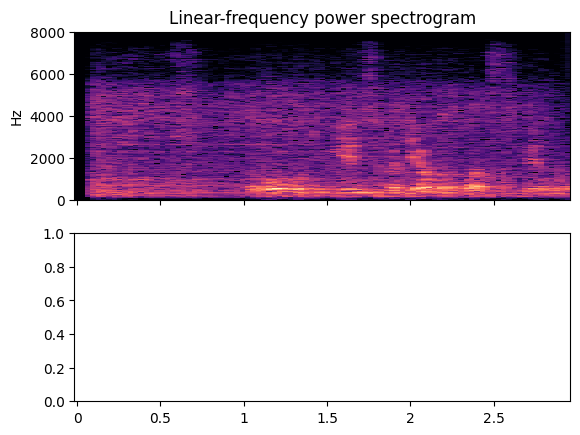

In [ ]:
y, sr = only_robot_ds["train"][0]['audio']['array'], only_robot_ds["train"][0]['audio']['sampling_rate']
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="Mihaj/wav2vec2-large-golos-robot-for-airi")

In [ ]:
def transcribe(audio):
    text = pipe(audio)["text"]
    return text

In [ ]:
def map_res_spell(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  fixed = speller.spelled(text)

  batch["pred_str"] = norm_string(fixed)
  batch["text"] = batch["transcription"]
  return batch

def map_res(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  batch["pred_str"] = norm_string(text)
  batch["text"] = batch["transcription"]
  return batch

In [ ]:
results_clean = only_robot_ds["test"].map(map_res_spell, remove_columns=only_robot_ds["test"].column_names)

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

<ipython-input-27-0dc5f81e0ca6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test WER: 0.111
Test CER: 0.054


In [ ]:
for i in range(len(results_clean["pred_str"])):
  print(f'{results_clean["pred_str"][i]} : {results_clean["text"][i]}')

робот едь вперед : робот едь вперед
робот ведь женщине в красном : робот едь к женщине в красном
едь к двери : едь к двери
робот едь назад : робот едь назад
проедь один метров : проедь один метр
повернись направо на десять градусов : повернись направо на десять градусов
повернись направо на пятнадцать градусов : повернись направо на пятнадцать градусов
повернись молила на двадцать градусов : повернись налево на двадцать градусов
проедь вперед : проедь вперед
едь вперед два метра : едь вперед два метра
едь к двери : едь к двери
работ повернись направо по часовой : работ повернись направо по часовой
едь налево : едь налево
сколько тебе лет : сколько тебе лет
робот детектируй женщину : робот детектируй женщину
повернись налево на двадцать пять градов : повернись налево на двадцать пять
возьми коронку : возьми коробку
проедь назад : проедь назад
едь к дивану : едь к дивану
едь назад : едь назад
де робот открой две : робот открой дверь


In [ ]:
results_clean = only_robot_ds["test"].map(map_res, remove_columns=only_robot_ds["test"].column_names)

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test WER: 0.208
Test CER: 0.068


In [ ]:
for i in range(len(results_clean["pred_str"])):
  print(f'{results_clean["pred_str"][i]} : {results_clean["text"][i]}')

робот едь вперед : робот едь вперед
робот едь женщине в краснов : робот едь к женщине в красном
едь к двери : едь к двери
робот едь назад : робот едь назад
проедь один метров : проедь один метр
повернись направо на десять градусов : повернись направо на десять градусов
повернись направо на пянадцать градосвов : повернись направо на пятнадцать градусов
повернись молело на двадцать градусов : повернись налево на двадцать градусов
проедь вперед : проедь вперед
едь вперед два метра : едь вперед два метра
едь к двери : едь к двери
робот повернись направо почасов : работ повернись направо по часовой
едь налево : едь налево
сколько тебе лет : сколько тебе лет
робот детектируй женщину : робот детектируй женщину
повернись налево на двадцать пять градо : повернись налево на двадцать пять
возьми ко ронку : возьми коробку
проедь назад : проедь назад
едь к девану : едь к дивану
едь назад : едь назад
де робот открой две : робот открой дверь


#Проверка с дообучением на аугментированном наборе

In [ ]:
!pip install pyaspeller

In [ ]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()

In [ ]:
from datasets import load_dataset, DatasetDict, concatenate_datasets, load_metric

In [ ]:
robot_ds = load_dataset("Mihaj/robot_ds_augmented_cv")
only_robot_ds = robot_ds.filter(lambda example: example["audio"]['path'] != None) # Настоящие данные с роботом
only_robot_ds

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/963 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/2287 [00:00<?, ? examples/s]

Filter:   0%|          | 0/963 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2287 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['transcription', 'audio'],
        num_rows: 963
    })
    train: Dataset({
        features: ['transcription', 'audio'],
        num_rows: 2287
    })
})

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="Mihaj/wav2vec2-large-golos-robot-for-airi", device=0)

In [ ]:
def transcribe(audio):
    text = pipe(audio)["text"]
    return text

In [ ]:
def map_res_spell(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  fixed = speller.spelled(text)

  batch["pred_str"] = norm_string(fixed)
  batch["text"] = norm_string(batch["transcription"])
  return batch

def map_res(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  batch["pred_str"] = norm_string(text)
  batch["text"] = norm_string(batch["transcription"])
  return batch

In [ ]:
results_clean = only_robot_ds["test"].map(map_res_spell, remove_columns=only_robot_ds["test"].column_names)

Map:   0%|          | 0/963 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test WER: 0.645
Test CER: 0.398


In [ ]:
for i in range(len(results_clean["pred_str"])):
  print(f'{results_clean["pred_str"][i]} : {results_clean["text"][i]}')

кокоеодстви течение ее позашинодтосонуко через проис : как и океанские течения усилия по защите морской среды должны течь через границы
стороной тут является связывающий сторож который и несерьезно : стороной тут является созывающая сторона которая и несет ответственность
малесничись не съезда : попрежнему чисто миссис батлер
какие отношения положительно вбегают на нашей специальной экономической различия : такие отношения положительно влияют на наше социальноэкономическое развитие
екате отказываться от него лепиду : с легкостью отказываться от него не следует
у него было влажное усталое лицо честно выполнившего своего дела рабочего человека : у него было влажное усталое лицо честно выполнившего свое дело рабочего человека
я ли видел что огделед время за дени пикаса но все таки в остео : левин видел что он берет ружьем сзади бекаса но всётаки выстрелил
ляеди два носки кио : я еду в белогорскую крепость
мы будем гарантировать право на работу достойной пенсии и социальную защиту : мы буд

In [ ]:
results_clean = only_robot_ds["test"].map(map_res, remove_columns=only_robot_ds["test"].column_names)

Map:   0%|          | 0/963 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test WER: 0.703
Test CER: 0.402


In [ ]:
for i in range(len(results_clean["pred_str"])):
  print(f'{results_clean["pred_str"][i]} : {results_clean["text"][i]}')

кокоеодстви течение ея позашинодтосонуко через проюс : как и океанские течения усилия по защите морской среды должны течь через границы
стороной тут является связывающий стороо который и несеръе : стороной тут является созывающая сторона которая и несет ответственность
малесничись не сезда : попрежнему чисто миссис батлер
какие отношения положительно вбелают на нашей споциальной кономической различи : такие отношения положительно влияют на наше социальноэкономическое развитие
ебкоте оказываться от него ле педу : с легкостью отказываться от него не следует
у него было влажное усталое лицо честно выполнившего своего дела робочего человека : у него было влажное усталое лицо честно выполнившего свое дело рабочего человека
яль ведель что огделед врьем за дени пи каса но все таки востео : левин видел что он берет ружьем сзади бекаса но всётаки выстрелил
ляеди два нодски кио : я еду в белогорскую крепость
мы будем карантировать право на работу достойнуй пенси и споциальную защиту : мы будем г

#Проверка без дообучения на аугментированном наборе

In [ ]:
!pip install pyaspeller

In [ ]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()

In [ ]:
from datasets import load_dataset, DatasetDict, concatenate_datasets, load_metric

In [ ]:
robot_ds = load_dataset("Mihaj/robot_ds_augmented_cv")
only_robot_ds = robot_ds.filter(lambda example: example["audio"]['path'] != None) # Настоящие данные с роботом
only_robot_ds

DatasetDict({
    test: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 21
    })
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 47
    })
})

In [ ]:
from transformers import pipeline

pipe = pipeline(model="bond005/wav2vec2-large-ru-golos", device=0)

In [ ]:
def transcribe(audio):
    text = pipe(audio)["text"]
    return text

In [ ]:
def map_res_spell(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  fixed = speller.spelled(text)

  batch["pred_str"] = norm_string(fixed)
  batch["text"] = norm_string(batch["transcription"])
  return batch

def map_res(batch):
  audio = batch["audio"]['array']
  text = transcribe(audio)
  batch["pred_str"] = norm_string(text)
  batch["text"] = norm_string(batch["transcription"])
  return batch

In [ ]:
results_clean = only_robot_ds["test"].map(map_res_spell, remove_columns=only_robot_ds["test"].column_names)

Map:   0%|          | 0/963 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test WER: 0.596
Test CER: 0.374


In [ ]:
for i in range(len(results_clean["pred_str"])):
  print(f'{results_clean["pred_str"][i]} : {results_clean["text"][i]}')

какотски течение д позашитастоу а : как и океанские течения усилия по защите морской среды должны течь через границы
стороной тут является связывающий сторонй который нечегоадъез : стороной тут является созывающая сторона которая и несет ответственность
лешнийчис не сезна : попрежнему чисто миссис батлер
такие отношения положительно отделяются на наше социально экономической различно : такие отношения положительно влияют на наше социальноэкономическое развитие
обкатки отказываться от него ни съедаю : с легкостью отказываться от него не следует
у него было влажное усталое лицо честно выполнившего своего тела рабочего человека : у него было влажное усталое лицо честно выполнившего свое дело рабочего человека
я е увидел что мидлет рон зидан питаса но все таки восстановить : левин видел что он берет ружьем сзади бекаса но всётаки выстрелил
для гены ивановской клада : я еду в белогорскую крепость
мы будем гарантировать права на работу достойной пенсию и социальную защиту : мы будем гарантир

In [ ]:
results_clean = only_robot_ds["test"].map(map_res, remove_columns=only_robot_ds["test"].column_names)

Map:   0%|          | 0/963 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_clean["pred_str"], references=results_clean["text"])))

Test WER: 0.647
Test CER: 0.380


In [ ]:
for i in range(len(results_clean["pred_str"])):
  print(f'{results_clean["pred_str"][i]} : {results_clean["text"][i]}')

какотски течение д позашитастоу а : как и океанские течения усилия по защите морской среды должны течь через границы
стороной тут является связывающий сторонй который нечегоадъез : стороной тут является созывающая сторона которая и несет ответственность
лешнийчис не сезна : попрежнему чисто миссис батлер
такие отношения положительно отделяютя на наше социально экономической различно : такие отношения положительно влияют на наше социальноэкономическое развитие
ебкаки оказываться от него ни седаю : с легкостью отказываться от него не следует
у него было влажное усталое лицо честно выполневшего своего тела ропотчего человека : у него было влажное усталое лицо честно выполнившего свое дело рабочего человека
я е уведел что мыделет рьон задин питаса но все таки востено : левин видел что он берет ружьем сзади бекаса но всётаки выстрелил
для гены дваноской кледа : я еду в белогорскую крепость
мы будем карантировать права на работу достойной пенсию и социальную защиту : мы будем гарантировать п

#Распознавание + данные из микро

In [ ]:
!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers
!pip install librosa
!pip install evaluate>=0.30
!pip install jiwer
!pip install gradio
!pip install audiomentations
!pip install transformers==4.30.0
!pip install accelerate==0.20.3
!pip install googletrans==3.1.0a0

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-iivq5zuf
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-iivq5zuf
  Resolved https://github.com/huggingface/transformers to commit a0042379269bea9182c1f87e6b2eee4ba4c8cce8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.4 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.32.0.dev0-py3-none-any.whl size=7436943 sha256=f1b4b33d3ef3ca65fd80221ab93d6d39fd70621d7a27ff964c88845f32d7df1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-wijswufc/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.0

In [ ]:
!pip install pyaspeller
from pyaspeller import YandexSpeller
speller = YandexSpeller()

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="Mihaj/wav2vec2-large-golos-robot-for-airi")  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    text = speller.spelled(text)
    return text

In [ ]:
# Step 1) Installation
!pip install -q ffmpeg-python SpeechRecognition gTTS pydub librosa tensorflow-text

# Step 2) Connect to GitHub
!git clone https://github.com/HonzaCuhel/mer-thesis-app

fatal: destination path 'mer-thesis-app' already exists and is not an empty directory.


In [ ]:
# Step 1) Imports
import sys
import gtts
import os
import IPython.display as display
import matplotlib.pyplot as plt
import librosa
import speech_recognition as sr

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/content/mer-thesis-app/')
from record_audio import get_audio
from predict_emotion_tf import *

In [ ]:
audio, sample_rate, audio_file = get_audio()

print('Speech recorded!')

Speech recorded!


In [ ]:
text = transcribe(audio)
text

'аоот провернись надцать градусов'

In [ ]:
from googletrans import Translator
translator = Translator()
translator.translate(text, src='ru', dest='ja').text

#Создать датасет еще больших размеров

In [ ]:
!pip install pyroomacoustics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.7.3-cp310-cp310-linux_x86_64.whl size=11861220 sha256=60de058e93a97fd2b5d76f132282d7956e5a9c3c223ec36a959d3b70a6ef2b61
  Stored in directory: /root/.cache/pip/wheels/6b/f3/67/0d0c4c06234c59c14e5ccf72774bd5c5f1b43c3083043c7fb7
Successfully built pyroomacoustics


In [ ]:
from datasets import load_dataset, DatasetDict, concatenate_datasets, load_metric, Audio

In [ ]:
import torch

In [ ]:
import pandas as pd

In [ ]:
def noising(wav, desire_snr_db=10):
    desire_snr_db = torch.Tensor([desire_snr_db])
    noise_samples = torch.randn(wav.shape)
    power_noise, power_wav = get_power(noise_samples), get_power(wav)

    noise_samples = noise_samples * torch.sqrt(power_wav / power_noise)
    snr = 10 ** (desire_snr_db / 10)

    noising_signal = torch.sqrt(snr) * wav + noise_samples
    noising_signal = noising_signal / torch.abs(noising_signal).max() * 0.4
    return noising_signal

def get_power(signal):
    return (signal**2).sum()

In [ ]:
from audiomentations import Compose, AddGaussianNoise, Limiter, TimeStretch, RoomSimulator, PitchShift, Shift, AddBackgroundNoise, PolarityInversion, AddGaussianSNR
augment = Compose([
    #Limiter(
    #    min_threshold_db=-16.0,
    #    max_threshold_db=-6.0,
    #    threshold_mode="relative_to_signal_peak",
    #    p=1.0,
    #  ),
    RoomSimulator(
        min_mic_distance=1.0,
        max_mic_distance=5.0,
        padding=2.0,
        use_ray_tracing=True,
        p=0.5,
    ),
    AddGaussianSNR(
      min_snr_db=1.0,
      max_snr_db=5.0,
      p=0.5
    ),
    #AddGaussianNoise(
    #  min_amplitude=0.01,
    #  max_amplitude=0.2,
    #  p=1.0
    #),
    AddBackgroundNoise(
    sounds_path="./noise",
    noise_rms="relative",
    min_snr_db=1.0,
    max_snr_db=5.0,
    min_absolute_rms_db=-30.0,
    max_absolute_rms_db=-3.0,
    noise_transform=PolarityInversion(),
    p=0.5
    ),
    #AddBackgroundNoise(
    #sounds_path="./noise",
    #noise_rms="absolute",
    #min_snr_in_db=35.0,
    #max_snr_in_db=50.0,
    #min_absolute_rms_db=-30.0,
    #max_absolute_rms_db=-3.0,
    #noise_transform=PolarityInversion(),
    #p=1.0
    #)
])
# augmented_samples = augment(samples=samples, sample_rate=16000)

In [ ]:
import soundfile as sf
import random
filenames_tr = []
transcriptions_tr = []
def noise_ds_audio_train(batch, sample_rate=48000):
  aug = augment(samples=batch['audio']['array'], sample_rate=sample_rate)
  i = random.randint(0, 100000)
  sf.write(f'train_{i}.wav', aug, sample_rate)
  filenames_tr.append(f'train_{i}.wav')
  transcriptions_tr.append(batch['sentence'])

filenames_t = []
transcriptions_t = []
def noise_ds_audio_test(batch, sample_rate=48000):
  aug = augment(samples=batch['audio']['array'], sample_rate=sample_rate)
  k = random.randint(0, 100000)
  sf.write(f'test_{k}.wav', aug, sample_rate)
  filenames_t.append(f'test_{k}.wav')
  transcriptions_t.append(batch['sentence'])


In [ ]:
from datasets import load_dataset, DatasetDict, concatenate_datasets, load_metric


cv_train = load_dataset("mozilla-foundation/common_voice_11_0", 'ru', split="train").train_test_split(test_size=0.1)['test']
cv_test = load_dataset("mozilla-foundation/common_voice_11_0", 'ru', split="test").train_test_split(test_size=0.1)['test']


cv_train = cv_train.filter(lambda x: x != None, input_columns=["sentence"])
cv_test = cv_test.filter(lambda x: x != None, input_columns=["sentence"])

cv_train.map(noise_ds_audio_train)
cv_test.map(noise_ds_audio_test)

Filter:   0%|          | 0/2287 [00:00<?, ? examples/s]

Filter:   0%|          | 0/963 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /content/noise/audio_27.wav had to be resampled from 16000 hz to 48000 hz. This hurt execution time.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /content/noise/audio_2.wav had to be resampled from 16000 hz to 48000 hz. This hurt execution time.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /content/noise/audio_21.wav had to be resampled from 16000 hz to 48000 hz. This hurt execution time.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /content/noise/audio_20.wav had to be resampled from 16

Map:   0%|          | 0/963 [00:00<?, ? examples/s]

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
    num_rows: 963
})

In [ ]:
filenames_t

['test_12465.wav',
 'test_75345.wav',
 'test_59853.wav',
 'test_31707.wav',
 'test_91752.wav',
 'test_70711.wav',
 'test_82758.wav',
 'test_87157.wav',
 'test_54278.wav',
 'test_55670.wav',
 'test_1934.wav',
 'test_37760.wav',
 'test_1549.wav',
 'test_61183.wav',
 'test_83346.wav',
 'test_6146.wav',
 'test_43834.wav',
 'test_38018.wav',
 'test_38666.wav',
 'test_54069.wav',
 'test_55912.wav',
 'test_41640.wav',
 'test_69547.wav',
 'test_70762.wav',
 'test_3361.wav',
 'test_71424.wav',
 'test_56637.wav',
 'test_86203.wav',
 'test_79641.wav',
 'test_94395.wav',
 'test_33696.wav',
 'test_69050.wav',
 'test_14712.wav',
 'test_49352.wav',
 'test_40585.wav',
 'test_5523.wav',
 'test_31594.wav',
 'test_34368.wav',
 'test_41955.wav',
 'test_4719.wav',
 'test_3053.wav',
 'test_79083.wav',
 'test_62064.wav',
 'test_91771.wav',
 'test_8074.wav',
 'test_35246.wav',
 'test_34861.wav',
 'test_54461.wav',
 'test_77908.wav',
 'test_14248.wav',
 'test_98745.wav',
 'test_39600.wav',
 'test_31683.wav',
 

In [ ]:
import pandas as pd
from datasets import Dataset

In [ ]:
train_noised = pd.DataFrame(list(zip(filenames_tr, transcriptions_tr)),
               columns =['filename', 'transcription'])
test_noised = pd.DataFrame(list(zip(filenames_t, transcriptions_t)),
               columns =['filename', 'transcription'])
train_noised['audio'] = train_noised['filename']
test_noised['audio'] = test_noised['filename']

In [ ]:
train_noised_dataset = Dataset.from_pandas(train_noised)
test_noised_dataset = Dataset.from_pandas(test_noised)

In [ ]:
from datasets import Audio

train_noised_dataset = train_noised_dataset.cast_column("audio", Audio(sampling_rate=16000))
test_noised_dataset = test_noised_dataset.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
test_noised_dataset = test_noised_dataset.remove_columns(["filename"])
train_noised_dataset = train_noised_dataset.remove_columns(["filename"])

In [ ]:
train_noised_dataset

Dataset({
    features: ['filename', 'transcription', 'audio'],
    num_rows: 2287
})

In [ ]:
from IPython import display
display.Audio(data=test_noised_dataset[1]['audio']['array'], rate=test_noised_dataset[0]['audio']['sampling_rate'])

In [ ]:
speech_noised_ds = DatasetDict()
speech_noised_ds['train'] = train_noised_dataset
speech_noised_ds['test'] = test_noised_dataset

In [ ]:
speech_noised_ds

DatasetDict({
    train: Dataset({
        features: ['transcription', 'audio'],
        num_rows: 2287
    })
    test: Dataset({
        features: ['transcription', 'audio'],
        num_rows: 963
    })
})

In [ ]:
speech_noised_ds.push_to_hub("Mihaj/robot_ds_augmented_cv")

Map:   0%|          | 0/763 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/762 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Map:   0%|          | 0/762 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Map:   0%|          | 0/482 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Map:   0%|          | 0/481 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
%pylab inline
import seaborn as sn
from scipy.stats import norm
import scipy.signal as sig
import copy

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip install datasets
from datasets import load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.3 MB/s eta 0:00:00


In [ ]:
robot_ds = load_dataset("Mihaj/robot_ds_augmented_cv")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/963 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/2287 [00:00<?, ? examples/s]

In [ ]:
import numpy as np

def signaltonoiseScipy(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

#SNRscipy = 20*log10(abs(signaltonoiseScipy(y)))

#print("SNR by scipy: {} dB".format(SNRscipy))

In [ ]:
robot_ds['test']['audio']

[{'path': 'test_12465.wav',
  'array': array([-9.01439307e-06, -3.51594063e-05, -9.03927230e-06, ...,
          1.40673639e-02,  1.89761724e-02,  1.60509981e-02]),
  'sampling_rate': 16000},
 {'path': 'test_75345.wav',
  'array': array([-1.10374349e-05, -3.23018539e-05, -2.82159272e-05, ...,
          2.62025595e-01,  2.19480127e-01,  1.66749954e-01]),
  'sampling_rate': 16000},
 {'path': 'test_59853.wav',
  'array': array([-6.10261850e-06, -5.53748487e-06, -7.00874170e-06, ...,
          1.61110442e-02,  8.81673582e-03,  5.76717407e-03]),
  'sampling_rate': 16000},
 {'path': 'test_31707.wav',
  'array': array([-0.03390531, -0.00180226,  0.04153131, ..., -0.04539804,
         -0.01423137, -0.00033671]),
  'sampling_rate': 16000},
 {'path': 'test_91752.wav',
  'array': array([ 0.04097574,  0.07347141, -0.00567232, ...,  0.05299209,
         -0.0055505 , -0.00011579]),
  'sampling_rate': 16000},
 {'path': 'test_70711.wav',
  'array': array([-0.05775171,  0.03580305,  0.03224296, ..., -0.

In [ ]:
sum = 0
for i in range(len(robot_ds['test']['audio'][:10])):
  res = 20*log10(abs(signaltonoiseScipy(robot_ds['test']['audio'][i]['array'])))
  sum += res
  print(i, res)
print(sum / len(robot_ds['test']))

0 -70.61989341226236
1 -48.635331231494874
2 -63.16600236511755
3 -52.53754422528331
4 -86.23785382444711
5 -63.932487306147124
6 -58.13753160548231
7 -64.2963488713162
8 -54.08917173222097
9 -90.44235458678456
-0.6771490333962163


In [ ]:
speech_clean_ds = DatasetDict()

speech_clean_ds['train'] = speech_ds_train
speech_clean_ds['test'] = speech_ds_test

#text_ds['train'] = rutexts_norm_train.train_test_split(test_size=0.1)
#text_ds['test'] = rutexts_norm_test.train_test_split(test_size=0.1)

print(speech_clean_ds)

speech_clean_ds["train"] = speech_clean_ds["train"]
speech_clean_ds["test"] = speech_clean_ds["test"]

speech_clean_ds= speech_clean_ds.map(norm_ds_text)
#speech_noise_ds= speech_clean_ds
#speech_noise_ds['test']= speech_clean_ds['test']
#speech_noise_ds= speech_noise_ds.map(noise_ds_audio)

print(speech_clean_ds)

In [ ]:
from IPython import display
display.Audio(data=speech_clean_ds["train"][1]['audio']['array'], rate=speech_clean_ds["train"][0]['audio']['sampling_rate'])

In [ ]:
from IPython import display
display.Audio(data=noising(speech_clean_ds["train"][1]['audio']['array']), rate=speech_clean_ds["train"][0]['audio']['sampling_rate'])

In [ ]:
from IPython import display
display.Audio(data=augment(samples=speech_clean_ds["train"][1]['audio']['array'], sample_rate=16000), rate=speech_clean_ds["train"][0]['audio']['sampling_rate'])